# Wasserstein Pareto Frontier Experiment on CRIME Data Set

## Import Data
The experiment used the CRIME data set as in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc. for comparison purpose: https://archive.ics.uci.edu/ml/datasets/communities+and+crime

In [45]:
import os
import ot
import math
import tempfile
import six.moves.urllib as urllib
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from scipy.linalg import sqrtm
from scipy import stats
from scipy.io import loadmat
from time import perf_counter
from tabulate import tabulate

# import data
path =r'/Users/shizhouxu/Documents/LIBRARY/Python/Fair_L2_Supervised_Learning/Communities-Crime/' # use your path
attrib = pd.read_csv(path + 'attributes.csv', delim_whitespace = True)
data = pd.read_csv(path + 'communities.data', names = attrib['attributes'])
data = data.drop(columns=['state','county','community','communityname','fold'], axis=1)
data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]
# clearning up the "Nan" in data
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])
data = data.dropna(axis=1)
# following "Fair Regression with Wasserstein Barycenters", we made the sensitive variable (race) binary for comparison purpose
# binary variable that indicating dominance of black race population in the community: brate_binary
brate = data['racepctblack']
np.unique(brate)
brate_binary = np.zeros(len(brate))

for i in range(0,len(brate)):
    brate_binary[i] = (brate[i] >= 0.3)*1
    
# independnet variable without race features (which are linearly dependnet of brate_binary): X_d
X_d = np.array(data.drop(['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'ViolentCrimesPerPop'],axis = 1))
# independnet variable that is a direct sum of X_d and brate_binary: X
X = np.concatenate((X_d,brate_binary[...,np.newaxis]),axis = 1)
# dependnet variable: Y
Y = np.array(data[['ViolentCrimesPerPop']])
# sensitive variable: Z
Z = X[:,96]

# five-fold cross validation data sets
trainX_list = []
trainX_d_list = []
trainY_list = []
trainZ_list = []
testX_list = []
testX_d_list = []
testY_list = []
testZ_list = []

for i in range(0,5):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, random_state=i)
    trainX_list.append(trainX)
    testX_list.append(testX)
    trainY_list.append(trainY)
    testY_list.append(testY)
    trainZ_list.append((trainX[:,96] == 1)*1)
    testZ_list.append((testX[:,96] == 1)*1)

for i in range(0,5):
    trainX_d, testX_d, trainY, testY = train_test_split(X_d, Y, test_size=0.1, random_state=i)
    trainX_d_list.append(trainX_d)
    testX_d_list.append(testX_d)

## Compute the Fair Data Representation (Wasserstein Pseudo-barycenter Pair)

In [47]:
# Compute the Wasserstein pseudo-barycenter for X
t = perf_counter() # time recording

# mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
X_d_mean = np.mean(X_d,axis = 0)
X_d_cov = np.cov(X_d.T)
Y_mean = np.mean(Y)
Y_cov = np.cov(Y.T)

# marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
X_A = X_d[X[:,96] == 0,:]
Y_A = Y[X[:,96] == 0]
X_C = X_d[X[:,96] == 1,:]
Y_C = Y[X[:,96] == 1]

X_A_mean = np.average(X_A, axis = 0)
Y_A_mean = np.average(Y_A)
X_C_mean = np.average(X_C, axis = 0)
Y_C_mean = np.average(Y_C)

X_A_cov = np.cov(X_A.T)
Y_A_cov = np.cov(Y_A.T)
X_C_cov = np.cov(X_C.T)
Y_C_cov = np.cov(Y_C.T)

# cross-covariance (matrix) between Y and X: yX_A(C)_cov
yX_A_cov = np.cov(Y_A.T, X_A.T)[range(1, 1 + len(X_d[0,:])),0]
yX_C_cov = np.cov(Y_C.T, X_C.T)[range(1, 1 + len(X_d[0,:])),0]

# algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.001
sample_size = len(X_d[:,0]) 
X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
eps = 10 # initialization for the stop variable

while eps > 0.001:
    X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
    eps = np.linalg.norm(X_bar - X_new)
    X_bar = X_new
    
# algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))

# wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
X_TrainFairList = []
X_TestFairList = []

X_fair = np.zeros(X_d.shape)
X_fair[X[:,96] == 0,:] = (X_d[X[:,96] == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
X_fair[X[:,96] == 1,:] = (X_d[X[:,96] == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y, test_size=0.5, random_state=i)
    X_TrainFairList.append(trainX)
    X_TestFairList.append(testX)

# Compute the Wasserstein Pseudo-barycenter for E(Y|X)

# marginal/conditional X_fair: X_fair_A(C)
X_fair_A = X_fair[X[:,96] == 0,:]
X_fair_C = X_fair[X[:,96] == 1,:]

# mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
X_fair_A_mean = np.average(X_fair_A, axis = 0)
X_fair_C_mean = np.average(X_fair_C, axis = 0)
X_fair_A_cov = np.cov(X_fair_A.T)
X_fair_C_cov = np.cov(X_fair_C.T)

# cross-covariance between Y and X_fair: yX_fair_A(C)_cov
yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,1 + len(X_d[0,:])),0]
yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,1 + len(X_d[0,:])),0]

# covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
# which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T

# algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.00000000001
Y_bar = np.random.rand()
eps = 10
while eps > 0.00000000001:
    Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
    eps = Y_bar - Y_new
    Y_bar = Y_new

# algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))

# wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
Y_TrainFairList = []
Y_TestFairList = []
Y_fair = np.random.rand(len(Y))

Y_fair[X[:,96] == 0] = ((Y[X[:,96] == 0] - Y_A_mean) * T_Y_A + Y_mean)[:,0]
Y_fair[X[:,96] == 1] = ((Y[X[:,96] == 1] - Y_C_mean) * T_Y_C + Y_mean)[:,0]

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y_fair, test_size=0.5, random_state=i)
    Y_TrainFairList.append(trainy)
    Y_TestFairList.append(testy)
    
time_fair = perf_counter() - t




<ipython-input-47-1fe29e69c9ac>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[X[:,96] == 0,:] = (X_d[X[:,96] == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-47-1fe29e69c9ac>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[X[:,96] == 1,:] = (X_d[X[:,96] == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean


In [48]:
time_fair

101.99186446199928

## Estimate the path of (X,Y) that results in the geodesic path from the E(Y|X_z) to the barycenter of the marginal conditional expectations
1. Compute both geodesic path path from X to X^dash and from Y to Y^dash
2. Use diagonal argument to estimate the geodesic path from the original E(Y|X) to E(Y^dash|X^dash) on both train and test data sets: X_train/test_path_list, Y_train\test_path_list

In [55]:
X_train_path_list = []
X_test_path_list = []
Y_train_path_list = []
Y_test_path_list = []

s = perf_counter()

T = np.linspace(0,1,50) # discretize time variable T

# Algorithm 1, step 3: estimate of the independent variable (X) geodesic path using McCann interpolation
for i in range(0,len(trainX_list)):
    X_d = trainX_d_list[i]
    Y = trainY_list[i]
    Z = trainZ_list[i]
    Z_test = testZ_list[i]
    # mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
    X_d_mean = np.mean(X_d,axis = 0)
    X_d_cov = np.cov(X_d.T)
    Y_mean = np.mean(Y)
    Y_cov = np.cov(Y.T)
    # marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
    X_A = X_d[Z == 0,:]
    Y_A = Y[Z == 0]
    X_C = X_d[Z == 1,:]
    Y_C = Y[Z == 1]
    X_A_mean = np.average(X_A, axis = 0)
    Y_A_mean = np.average(Y_A)
    X_C_mean = np.average(X_C, axis = 0)
    Y_C_mean = np.average(Y_C)
    X_A_cov = np.cov(X_A.T)
    Y_A_cov = np.cov(Y_A.T)
    X_C_cov = np.cov(X_C.T)
    Y_C_cov = np.cov(Y_C.T)
    # cross-covariance (matrix) between Y and X: yX_A(C)_cov
    yX_A_cov = np.cov(Y_A.T, X_A.T)[range(1, 1 + len(X_d[0,:])),0]
    yX_C_cov = np.cov(Y_C.T, X_C.T)[range(1, 1 + len(X_d[0,:])),0]
    # algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.00000000000
    sample_size = len(X_d[:,0]) 
    X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
    eps = 10 # initialization for the stop variable
    while eps > 0.000001:
        print(eps)
        X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
        eps = np.linalg.norm(X_bar - X_new)
        X_bar = X_new
    # algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
    T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
    T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))
    # wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
    X_fair = np.random.rand(X_d.shape[0],X_d.shape[1])
    X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
    X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean
    # generate the geodesic path
    X_train_path = []
    X_test_path = []
    for t in range(0,len(T)):
        temp = np.zeros(X_d.shape)
        temp_test = np.zeros(testX_d_list[i].shape)
        temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        temp_test[Z_test == 0,:] = (1-T[t])*testX_d_list[i][Z_test == 0,:] + T[t]*((testX_d_list[i][Z_test == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp_test[Z_test == 1,:] = (1-T[t])*testX_d_list[i][Z_test == 1,:] + T[t]*((testX_d_list[i][Z_test == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        # Algorithm 1, step 4: merge the corresponding (wrt t) linear interpolation of sensitive variable back to the MacCann interpolation of dependnet variable
        temp_more = np.concatenate((temp, Z[...,np.newaxis]),axis = 1)
        temp_more_test = np.concatenate((temp_test, Z_test[...,np.newaxis]),axis = 1)
        X_train_path.append(temp_more)
        X_test_path.append(temp_more_test)
    
    # Compute the Wasserstein Pseudo-barycenter for E(Y|X)
    # marginal/conditional X_fair: X_fair_A(C)
    X_fair_A = X_fair[Z == 0,:]
    X_fair_C = X_fair[Z == 1,:]
    # mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
    X_fair_A_mean = np.average(X_fair_A, axis = 0)
    X_fair_C_mean = np.average(X_fair_C, axis = 0)
    X_fair_A_cov = np.cov(X_fair_A.T)
    X_fair_C_cov = np.cov(X_fair_C.T)
    # cross-covariance between Y and X_fair: yX_fair_A(C)_cov
    yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,1 + len(X_d[0,:])),0]
    yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,1 + len(X_d[0,:])),0]
    # covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
    # which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
    yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
    yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T
    # algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    Y_bar = np.random.rand() 
    eps = 10
    while eps > 0.000001:
        Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
        eps = Y_bar - Y_new
        Y_bar = Y_new 
    # algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
    T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
    T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))
    # wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
    Y_fair = np.random.rand(len(Y))
    Y_fair[Z == 0] = ((Y[Z == 0] - Y_A_mean) * T_Y_A + Y_mean)[:,0]
    Y_fair[Z == 1] = ((Y[Z == 1] - Y_C_mean) * T_Y_C + Y_mean)[:,0]
    # generate the geodesic path
    Y_train_path = []
    Y_test_path = []
    for t in range(0,len(T)):
        temp = np.random.rand(len(Y))
        temp_test = np.random.rand(len(testY_list[i]))
        temp[Z == 0] = ((1 - T[t] + T[t]*T_Y_A)*Y[Z == 0] + T[t]*(Y_mean - T_Y_A*Y_A_mean))[:,0]
        temp[Z == 1] = ((1 - T[t] + T[t]*T_Y_C)*Y[Z == 1] + T[t]*(Y_mean - T_Y_C*Y_C_mean))[:,0]
        temp_test[Z_test == 0] = ((1 - T[t] + T[t]*T_Y_A)*testY_list[i][Z_test == 0] + T[t]*(Y_mean - T_Y_A*Y_A_mean))[:,0]
        temp_test[Z_test == 1] = ((1 - T[t] + T[t]*T_Y_C)*testY_list[i][Z_test == 1] + T[t]*(Y_mean - T_Y_C*Y_C_mean))[:,0]
        Y_train_path.append(temp)
        Y_test_path.append(temp_test)
        
    X_train_path_list.append(X_train_path)
    X_test_path_list.append(X_test_path)
    Y_train_path_list.append(Y_train_path)
    Y_test_path_list.append(Y_test_path)
    
time_fair = perf_counter() - s

10
56.20470009234968
42.62836743646279
65.94007670094446
183.80235873060917
229.5130378226758
278.74617166589206
306.6477332293429
328.0019570701892
350.08310490333275
366.1352608345001
376.1628160746685
379.681262824998
376.5507383143041
375.3893934221821
372.1320908253209
356.59875127454177
351.09128391544374
340.0355816833378
340.10495068323667
330.5523081520846
330.89353466861115
330.01013538094975
335.83653097392096
330.2726641371863
350.3822582685061
323.7143926049148
327.26911881621925
294.39026891228116
303.95795661675
264.0397759679362
281.77085313739536
242.39988888075956
216.35309977538986
178.81997814938367
161.86162099759727
158.28121494956048
149.75943988156334
154.37361427198942
172.97405287126372
178.58179771218283
149.5357916040391
172.54165413671632
147.6527285160695
132.55680686680523
152.48611326518213
111.86344285701313
130.31629270349268
112.18768045938057
127.45803385697587
121.54690254222133
112.65511613072202
124.29826203305662
114.97757676424685
120.4850298382

510.5230058309107
515.8549369890186
512.6804455404784
516.7594871895018
510.6965051089662
517.013079278271
513.809247077863
518.6059934249868
512.8923173356686
519.6453341352458
516.809887985145
521.9257127480543
516.5130636331937
523.5413213801861
521.0064402520312
526.4029140051697
521.2219985614664
528.534276333869
526.2575739347658
531.9468975186912
526.9576523528217
534.564717127801
532.5163254759949
538.525377431429
533.7106460937442
541.6407404930835
539.8144991734555
546.1644753411782
541.5181339547432
428.84989324311573
363.2386117840016
457.52780983005033
497.3986601848919
413.8421486503049
361.2175266583448
350.5118725705172
336.28780283595967
339.5959124992095
336.36180964440285
341.3673775415426
337.51604150972076
256.2696073690105
580.2144710824113
502.25042245631016
461.61881021336086
373.71690902370347
262.92274996853024
593.4704381401529
502.4103122350359
460.6540250142057
371.54980548045074
261.2902371696707
591.0503823290687
500.658333637598
282.2246381529741
646.214

0.00479303046995604
0.00473322984056832
0.004674920627902573
0.0046180427589736645
0.0045625396748774924
0.004508357858694407
0.004455446738274283
0.004403758670744225
0.0043532483111264186
0.00430387272296852
0.004255591214242502
0.004208365200901153
0.004162157845995495
0.004116934193587243
0.00407266100914612
0.004029306438684969
0.003986840281119047
0.003945233605104316
0.0039044589638705424
0.0038644898802874168
0.0038253010007280324
0.0037868683437971102
0.003749168671184889
0.003712179863453318
0.0036758806878725674
0.0036402506886519946
0.003605270248499117
0.003570920661053308
0.003537183903728302
0.003504042526073627
0.003471479808532084
0.003439479666798606
0.003408026680160252
0.0033771059052176027
0.0033467029866725514
0.00331680415488154
0.00328739594422705
0.003258465528092863
0.0032300005393889075
0.0032019889252631263
0.0031744191321002703
0.00314727995423055
0.0031205606528933454
0.0030942507012869437
0.0030683401413770235
0.003042819144453534
0.0030176782045015075
0.

0.0004797804374626176
0.00047750359464963227
0.00047523807809717527
0.0004729838326348023
0.000470740794959578
0.0004685088957373523
0.00046628808093179727
0.000464078287863383
0.0004618794564452864
0.000459691524671109
0.00045751443962824945
0.00045534813382543403
0.000453192552695329
0.0004510476374043332
0.0004489133299404961
0.00044678957122575263
0.00044467630063740177
0.00044257347043691727
0.0004404810165264393
0.000438398885475514
0.0004363270226377156
0.0004342653697540546
0.00043221387125855177
0.0004301724735847565
0.0004281411256364922
0.0004261197738906456
0.00042410835408189187
0.0004221068245236151
0.00042011512294341525
0.0004181332036740202
0.000416161017816834
0.00041419850097239677
0.0004122456124389389
0.0004103022987067615
0.00040836850342655635
0.00040644417597904704
0.0004045292764601331
0.0004026237416475818
0.000400727534558426
0.000398840595457455
0.00039696287939923773
0.00039509433604383167
0.00039323491819612326
0.00039138458085591707
0.0003895432682616073


8.75422254139793e-05
8.714155851285097e-05
8.674274149023174e-05
8.634576713933503e-05
8.595062561706484e-05
8.555730917645138e-05
8.516580964419151e-05
8.477611791457531e-05
8.438822477372911e-05
8.40021222455133e-05
8.361780305217307e-05
8.323525764828605e-05
8.285447724991155e-05
8.247545559611427e-05
8.209818349618771e-05
8.172265208301817e-05
8.134885395372525e-05
8.097678065695047e-05
8.060642425275274e-05
8.023777631948572e-05
7.987082906451653e-05
7.950557470474825e-05
7.914200508698511e-05
7.878011276773933e-05
7.841989009129237e-05
7.806132798693736e-05
7.770442026835893e-05
7.734915848336988e-05
7.699553433427843e-05
7.664354119739539e-05
7.629317116889976e-05
7.594441619373071e-05
7.559726886655676e-05
7.525172131153358e-05
7.490776776536491e-05
7.45653998646105e-05
7.422460942391717e-05
7.388538935708024e-05
7.354773265261206e-05
7.321163199444076e-05
7.287708036319838e-05
7.254406980229601e-05
7.22125936899823e-05
7.188264452472316e-05
7.155421564030231e-05
7.122729929612

1.6345576574777824e-05
1.6271548948295878e-05
1.619785818355082e-05
1.6124502651746347e-05
1.605148071515148e-05
1.5978790844249752e-05
1.590643162320959e-05
1.583440139712663e-05
1.5762698842593338e-05
1.5691322270598912e-05
1.5620270316136316e-05
1.5549541502773634e-05
1.5479134263143997e-05
1.5409047073437106e-05
1.5339278720252444e-05
1.526982756363351e-05
1.520069215705355e-05
1.5131871126287e-05
1.50633629116042e-05
1.4995166241251845e-05
1.4927279596122768e-05
1.4859701589659273e-05
1.4792430726573008e-05
1.4725465756721386e-05
1.4658805187594626e-05
1.4592447590033384e-05
1.4526391635913923e-05
1.4460635871482622e-05
1.4395179074224825e-05
1.4330019808412833e-05
1.426515674218212e-05
1.4200588350039599e-05
1.4136313497529309e-05
1.4072330813078789e-05
1.4008638765522774e-05
1.3945236303121469e-05
1.3882121891716052e-05
1.3819294286163366e-05
1.3756752245218199e-05
1.3694494339305721e-05
1.3632519429823643e-05
1.357082607272426e-05
1.3509413086611006e-05
1.3448279049500958e-05
1

3.091155687614641e-06
3.0772329338722337e-06
3.0633730591649812e-06
3.049575732035634e-06
3.0358407182399724e-06
3.0221677152038274e-06
3.008556457091948e-06
2.995006632924335e-06
2.9815179878405174e-06
2.9680902642704753e-06
2.9547231358774745e-06
2.9414163754279415e-06
2.928169666012956e-06
2.914982772358121e-06
2.9018554215248357e-06
2.8887873074872807e-06
2.8757781953038763e-06
2.8628278147891135e-06
2.849935903778235e-06
2.837102185643059e-06
2.824326403606898e-06
2.811608284232897e-06
2.798947565943326e-06
2.7863439939917626e-06
2.7737973196861354e-06
2.7613072595923516e-06
2.7488735880187736e-06
2.7364960516684163e-06
2.724174374601648e-06
2.7119083053065346e-06
2.6996975906505223e-06
2.6875420095467355e-06
2.6754412743799487e-06
2.6633951559145153e-06
2.6514033901143773e-06
2.639465783514556e-06
2.627582023527333e-06
2.6157518795782173e-06
2.603975148665039e-06
2.592251564721208e-06
2.580580884482508e-06
2.5689628611541995e-06
2.557397261289773e-06
2.545883874727867e-06
2.53442

<ipython-input-55-8e210aed2c81>:51: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-55-8e210aed2c81>:52: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean
<ipython-input-55-8e210aed2c81>:59: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
<ipython-input-55-8e210aed2c81>:60: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
<ipython-input-55-8e210aed2c81>:61: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_test[Z_test == 0,:] = (1-T[t])*testX_d_list[i][Z_test == 0,:] + T[t]*((testX_d_list[i][Z_test == 0,:] 

10
96.57422384870564
104.0166482550318
89.37700239899726
80.66964035514222
95.13319402125896
95.69314120978903
83.80079536692857
91.72360634570914
74.05035953121454
86.45860509270416
112.50264340122351
83.35194522591526
72.0250777704929
84.66856661516714
68.40181827959682
73.99664478815195
58.730773735590724
54.541002271577426
67.88466380955072
81.73238375696934
93.24658938682803
97.4053833863025
90.85785826622792
61.88618053546883
46.211370046973094
37.797428956566314
33.79446558429898
103.36848609700189
64.65061424454255
43.87892078555739
47.276662502552355
67.80767063880597
116.08201839216774
97.017847244581
79.87164150450349
73.09814656791136
114.12417677217384
100.28458731536816
93.83817551004684
123.1668099395765
148.9988359182427
157.03914418205878
146.44764251206652
120.54196517975414
132.64519835293808
119.58070633508859
82.65664995216532
80.68298687285885
101.28774860605103
90.03518901444005
73.91156704775615
75.5613294046772
103.94178717337732
122.2225233305318
133.379513707

144.2168317471694
156.11821187731564
95.78311073398672
49.55405634362929
23.604343269925153
12.007497608578678
88.38103048876484
33.68770801920481
167.04280092699463
129.93999507992334
68.53859360007412
32.23762790367869
15.06970982938258
8.259274662959402
6.326478690222103
150.3346944640807
98.04523629177213
49.10700796952369
22.39989594766373
9.871950025072119
5.514514527661412
5.325443189948132
5.604179996831919
6.327716608218467
5.6845034076833505
5.960148246101006
5.885810027998719
6.1362704685580995
5.698634127890487
6.0586616888099805
5.2814639399600285
6.018714873410578
5.848319727579553
20.660634736677025
11.399757887892077
7.648218010309053
7.108769616353606
10.753859446010082
13.440107188069403
13.233284858980493
11.0834551176301
8.302951662403556
5.9085198123394855
4.434678849810101
3.259775201576292
2.539484811156897
2.222598603908774
2.1074824601963447
2.103217373551412
1.9734053908940927
1.9985502978093568
2.109563994980514
2.1341087696220202
2.1271921199201933
2.1115091

2.2759398931989367
1.4772893499985944
1.6076701677322476
1.8558891343221917
2.057923700890567
2.1973520803324673
1.4691818820339284
1.5558174411887593
1.802119268095668
2.015266249385471
2.164740497505172
2.2624978650664977
1.4705504237279101
1.608928170242326
1.8631253721175338
2.0650249272792416
2.2062560718210746
1.4733916562670666
1.562181681520498
1.809781508392925
2.024100609567472
2.1738278739051653
1.4554091420609874
1.5509697921065915
1.8034869505817401
2.020829252954166
2.1760270792569476
1.4560608897946052
1.5548163183652441
1.8107851399497792
2.0307878159666592
2.1859088112608585
1.4383248776543638
1.602557772154454
1.8692068995512563
2.080858079534478
2.2258887792919904
1.4663557528951094
1.6257072562220163
1.8891833834369045
2.100265574425884
2.2439927038013594
1.479035623256277
1.6395886028301088
1.904826542216236
2.1145319110592897
2.2571903987437985
1.49031045794061
1.6510592916590114
1.9159282612255615
2.1261039933294463
2.2718416856040324
1.501568096466442
1.66236110

1.3223484300573984
1.2557933835497759
1.1417943893427305
1.0037862199611578
0.8674184793731953
0.7511486764548175
0.6626212234677156
0.6004625411192384
0.5585329017837045
0.5299191975808424
0.5091320125774927
0.4925768221359554
0.4781729535131744
0.4648156937310098
0.45196024525455114
0.43936136538161447
0.4269268500500604
0.4146394586937747
0.4025163324267142
0.39058788738825656
0.3788870341125396
0.36744369507686264
0.3562823093364615
0.34542094937457235
0.33487153227050015
0.3246403664430515
0.3147290404157124
0.30513531912898073
0.295854031707395
0.28687786931092746
0.2781980752351347
0.26980487784101137
0.26168800263882636
0.2538369458474756
0.24624119464347669
0.23889041793399451
0.23177456781026198
0.22488393269397372
0.21820918334392442
0.21174139951887835
0.2054720653982659
0.19939306806513754
0.19349668449066354
0.18777558411880363
0.18222281790928924
0.17683177512528364
0.17159620186223384
0.16651016411211542
0.16156806271548282
0.15676459040470198
0.1520947363405068
0.14755

0.0019550025074484495
0.0019447055353781183
0.0019344703408235618
0.0019242962710411986
0.001914183015231578
0.0019041299949943975
0.0018941367033728377
0.001884202742072423
0.001874327525050535
0.001864510715136154
0.0018547517942510059
0.0018450503412840665
0.0018354058911677152
0.0018258179856751155
0.0018162861929324696
0.0018068101138056228
0.001797389366534686
0.0017880233921099573
0.0017787118887436489
0.0017694544258965857
0.001760250560976511
0.001751099912832963
0.0017420021045606636
0.0017329566834053901
0.0017239634119358663
0.0017150217699602262
0.0017061313878954814
0.0016972919054399104
0.0016885029515145457
0.0016797642038858126
0.0016710752243470274
0.0016624357265880396
0.001653845304575613
0.0016453036592210509
0.0016368104002585904
0.0016283652318665803
0.0016199677425382945
0.0016116176453217306
0.0016033146158416496
0.0015950582457044933
0.0015868483067158798
0.0015786843855640233
0.0015705662692431668
0.001562493568251907
0.0015544660015715103
0.00154648325466987

0.00030143646630003437
0.00029997121805695076
0.0002985132131496132
0.00029706241531841297
0.0002956187861165208
0.0002941822932738781
0.00029275289845698727
0.00029133056572301327
0.00028991525787029805
0.000288506941826233
0.00028710558283303743
0.00028571114510526414
0.00028432359348658123
0.00028294289139091513
0.0002815690077260399
0.0002802019050172851
0.0002788415508691223
0.00027748791126731045
0.000276140951341073
0.0002748006407197866
0.0002734669416465793
0.00027213982214355204
0.00027081924808917
0.00026950518910605386
0.0002681976123764521
0.000266896482560324
0.0002656017696649841
0.00026431344001934324
0.00026303146325661113
0.00026175580570029605
0.00026048643476256486
0.0002592233213424599
0.00025796643182488807
0.00025671573624867864
0.0002554712039259222
0.00025423280253176453
0.0002530005022361208
0.00025177427149901095
0.00025055407995590876
0.00024933989762596765
0.0002481316942169036
0.00024692944018516204
0.0002457331056002843
0.0002445426598896918
0.00024335807

5.186266102816046e-05
5.1616811736223637e-05
5.137214190701945e-05
5.112864574456574e-05
5.088631792176449e-05
5.064515235432129e-05
5.0405144007435116e-05
5.0166286993327846e-05
4.992857573442418e-05
4.969200423889608e-05
4.94565672319223e-05
4.922225930353199e-05
4.898907485661654e-05
4.87570088359161e-05
4.8526055043779446e-05
4.829620909680565e-05
4.80674641087476e-05
4.783981589599223e-05
4.761325900357412e-05
4.738778785771804e-05
4.716339725824295e-05
4.694008216874777e-05
4.671783697817299e-05
4.649665684172117e-05
4.6276536372775956e-05
4.6057470421726614e-05
4.5839453965289594e-05
4.562248210127699e-05
4.540654957806648e-05
4.519165102754638e-05
4.497778167547096e-05
4.4764936479948906e-05
4.4553110833337705e-05
4.434229928795624e-05
4.413249725988956e-05
4.392369995094609e-05
4.3715902189960554e-05
4.3509098778167645e-05
4.330328577024463e-05
4.3098457497336354e-05
4.289460969131944e-05
4.269173765445418e-05
4.248983642507798e-05
4.2288901715245256e-05
4.2088928272389444e-05

9.352028482799974e-06
9.30850722321741e-06
9.265190460635248e-06
9.222077104881222e-06
9.17916630923038e-06
9.136457074584867e-06
9.093948462055936e-06
9.051639408615519e-06
9.009529045394568e-06
8.967616420591534e-06
8.92590055029101e-06
8.884380626901415e-06
8.843055588023118e-06
8.80192455844688e-06
8.760986677852622e-06
8.720240920234708e-06
8.679686477115032e-06
8.639322343067067e-06
8.599147718595197e-06
8.559161570086973e-06
8.519363176901893e-06
8.479751487427609e-06
8.440325687554637e-06
8.401084870773481e-06
8.362028211381675e-06
8.323154851942143e-06
8.284463865916267e-06
8.245954377664318e-06
8.20762554486723e-06
8.169476483741295e-06
8.131506439174072e-06
8.093714504858914e-06
8.056099743481041e-06
8.018661502769077e-06
7.981398776472388e-06
7.944310792009096e-06
7.907396756249368e-06
7.87065576418578e-06
7.834087126870502e-06
7.797689906256976e-06
7.761463342535644e-06
7.725406616060634e-06
7.689518924624134e-06
7.65379953295865e-06
7.618247506751934e-06
7.582862176894371

1.6861474529058181e-06
1.6784108609870715e-06
1.6707100130225452e-06
1.6630447655843414e-06
1.6554149164884477e-06
1.6478203276590146e-06
1.6402608218411876e-06
1.6327362456596967e-06
1.625246431947542e-06
1.6177912164836881e-06
1.6103704505333275e-06
1.6029839544417202e-06
1.5956315901192636e-06
1.5883131755924908e-06
1.5810285774053175e-06
1.5737776195665275e-06
1.5665601517875214e-06
1.559376000672118e-06
1.552225038455516e-06
1.5451071044643384e-06
1.5380220401633995e-06
1.5309696912222673e-06
1.523949903482828e-06
1.5169625255230856e-06
1.5100074017422213e-06
1.5030844017559025e-06
1.4961933657257657e-06
1.4893341471734437e-06
1.4825065880235881e-06
1.475710546854041e-06
1.4689458780620664e-06
1.4622124343780818e-06
1.4555100672433768e-06
1.448838632400625e-06
1.4421980038942554e-06
1.4355879941433287e-06
1.42900851630884e-06
1.4224593955205012e-06
1.4159405038174731e-06
1.4094516784050792e-06
1.4029927983026064e-06
1.3965637283319736e-06
1.3901643202574654e-06
1.3837944313409416e

1763.5702766278257
1308.3394487095668
716.3517703235746
378.7662568658918
1721.5433228865616
1277.4400610519385
709.6851798135822
368.79043297198984
1679.9763612999002
1257.6181568544853
701.7925015272743
1641.2111635010856
1295.1212422810445
717.5735999553685
378.5528854148075
1626.4661178586587
1210.4319434167019
671.7869498141326
1559.765794857638
1228.8928763522372
679.1007472205807
1511.3980516744411
1208.5581231582514
680.8478800559259
1494.2271883295707
1201.1514183738134
678.1311662017147
1478.4209171762238
1176.6069025079605
651.7828629469334
1442.4526230718789
1148.7727783757675
635.7577485988093
1397.4935068512762
1118.2914251477878
630.2759909056318
1382.2594333469237
1111.7091098145959
627.6043480103293
1370.650967889093
1090.5781891357424
612.2508553839187
1331.6410339030601
1058.489724576136
584.7922477235238
1293.1315845722356
1029.3739617323088
568.9809547434639
1250.967371752885
1002.4026740093971
565.4556473928368
1239.1438744904651
997.8165938717062
563.673186391474

6.328982517612244
5.3875296399954316
5.5927034397677335
5.618183880277854
6.015004655722772
6.940664964351195
7.414999453859919
5.798519354358694
6.504530111274207
7.04294118599009
6.367606276006963
5.5760449783365456
5.330233734558129
6.154723534883073
5.869438695635661
5.873405629328844
5.529795079467178
4.536483184837236
5.339153227340878
5.50627714195641
5.258953441782026
6.2966598346094615
6.3024679176113905
7.061678798847023
7.508498360996932
6.232691065458956
6.680955867006073
5.491511561307118
5.098451006624451
5.403142804295663
5.864081606148098
6.040364807706689
4.983048592271568
5.730348812009998
6.7110976456652605
7.31724637034056
7.264970634701106
7.273887719960115
5.92088461794405
6.11223865889117
5.054361429162955
4.11733875077502
4.252514657273434
4.127547659132795
4.879175029018354
5.343553645342725
5.765740346373243
5.908937583249512
6.201396926616596
5.938047531673162
5.944102499908653
6.564990525430319
6.9158898403752245
6.4522522575447825
5.212185645866574
5.471965

1078.8658494785682
731.7018077016706
417.824126555818
223.03832124934902
1719.518996944417
1071.8082571808686
725.6054170985373
415.0794711614423
222.3774478728083
1708.923105677237
1064.072392908604
721.5668537611433
413.0696479056454
221.1645980767792
1699.7139777736616
1060.4285543643653
719.3102789476492
409.9112054062397
218.63059148885358
1690.2504721190546
1052.9491252230614
714.3129205370494
407.93519042930905
218.45559824924553
1678.3069059549086
1045.4682550550242
708.7099561432256
405.38836977231597
215.62468130976148
1667.554602445738
1038.4273969290884
704.243548929222
401.936805681046
215.34795964671184
1657.5787748215464
1033.2662697618264
699.8715873667741
400.60491670672343
214.71630713434095
1648.7283817983293
1027.6347342186089
696.8277681612723
398.4087622772474
212.58189220023652
1640.1905382134964
1021.7267177335957
693.0631327311116
396.6093606060855
212.8219670404325
1631.9513678543492
1015.8983647495601
688.6469886006087
393.6596198683642
211.2089652394931
2083

1806.3359353337498
1351.5774574878697
739.5873243547552
379.5370560536549
1806.208265887388
1352.5558526180994
740.181147384953
379.93758807494123
1807.618040454171
1353.8904794381338
742.5328327419656
381.4168559672422
1814.540733963506
1359.5197606940135
745.6115256476202
383.38542031384793
1820.955305021806
1364.2133291661958
748.5053994141451
384.8988911585135
1825.3372287253394
1366.293598356115
749.5825798392342
383.34990181330585
1825.576954494169
1365.3245542516422
746.5016913340332
383.513582034782
1823.0812972870146
1364.7473952815062
748.8683497355951
383.2902437301691
1825.0843087068463
1366.2302549568915
749.5497477321455
385.88626007293107
1828.7837608116463
1368.25667551006
748.4964080679243
384.3012400642862
1828.464583599139
1369.2249746084892
750.774993895068
384.51058904711476
1828.4609148014135
1368.5255312136142
750.4400517635917
383.9660073805127
1827.0002571588445
1367.2527203612196
748.5669870057283
383.5545363939377
1826.9609846125581
1368.219415053123
748.7124

1375.8926395678745
1365.0113279774282
1352.195211920875
1040.8982663698016
2346.3951941713863
2076.1140428235494
1866.3046775110295
1511.5079898590636
1474.9847559685559
1405.0688148294103
1397.6050193517542
1382.7331153178977
1376.7833455382788
1380.4959030415268
1380.718753232921
1384.6554336314398
1380.589795571394
1389.0737998393433
1389.786329691183
1395.7777504955332
1393.7791807604242
1397.1328443413568
1395.0891407990662
1400.0774736212986
1396.7261892009903
1399.618101370809
1397.5170281852104
1402.67393414704
1399.2295032495974
1403.0882132214726
1401.5203016387889
1407.9658743221507
1405.02450195247
1409.6453598176563
1406.9647962448091
1413.73837664625
1410.6882200738705
1415.8429290924012
1415.2572426645725
1421.8891059092457
1419.5410616591507
1423.5140362056654
1421.543916911705
1427.85184851838
1425.0668031687278
1430.8009508852062
1429.6021425266822
1436.6020416240556
1433.9563887431048
1438.1387276147407
1436.4368007872201
1442.8232740201377
1440.0492864503035
1444.78

0.13563316906786715
0.12460393066895965
0.11532021895587527
0.10737704632849876
0.10046886967473441
0.09436621124334008
0.08889743367000431
0.08393478154235498
0.07938372342016993
0.07517478960014502
0.07125728118023511
0.06759440107224335
0.0641594625087257
0.06093294299426393
0.05790020784673707
0.05504977358787315
0.052372021122087095
0.04985827884448103
0.04750021771432542
0.04528949694527219
0.04321760797073461
0.04127586388148321
0.039455481736386265
0.03774771905454386
0.03614402859120664
0.03463620280779685
0.0332164945307553
0.03187770300518571
0.030613225263498443
0.029417075361859397
0.028283876689422317
0.027208833783053617
0.026187691336997204
0.025216683790354848
0.024292482437823566
0.023412142241413515
0.022573050557862313
0.021772879561596764
0.021009542942268214
0.020281157931677646
0.019586011745108062
0.01892253257317682
0.018289265483079215
0.01768485221635008
0.017108014396709163
0.01655754071992597
0.016032276147823727
0.015531114524991362
0.015052992739578804
0.

0.000738909182552422
0.0007347736802702141
0.0007306644082842533
0.0007265811674693536
0.0007225237559541552
0.0007184919845077105
0.0007144856552725832
0.000710504566868373
0.0007065485360597762
0.0007026173762959739
0.0006987108989311464
0.0006948289141893558
0.0006909712445132423
0.0006871377061617878
0.0006833281111437653
0.0006795422893903736
0.0006757800626087382
0.0006720412502777687
0.000668325684983014
0.0006646331903906979
0.0006609635953031527
0.0006573167354439275
0.0006536924432130245
0.0006500905473877451
0.0006465108889778521
0.0006429533028943948
0.0006394176260757462
0.000635903700308003
0.0006324113616204808
0.0006289404642128096
0.0006254908454318393
0.0006220623510096806
0.00061865482742944
0.000615268124020519
0.0006119020922925095
0.0006085565821676321
0.0006052314455154539
0.0006019265380002521
0.0005986417123525547
0.0005953768292001619
0.0005921317405425821
0.000588906307866853
0.0005857003912576882
0.000582513854042983
0.0005793465537089461
0.00057619835762750

0.00011134559312141918
0.00011080022027904607
0.00011025761607593607
0.00010971776578078466
0.00010918065576290919
0.00010864627044867298
0.00010811459568840624
0.0001075856170497501
0.00010705932036022685
0.00010653569030042095
0.00010601471369208406
0.00010549637651980002
0.00010498066458464159
0.00010446756354980551
0.0001039570596430094
0.0001034491390713067
0.00010294378852035492
0.00010244099365325725
0.00010194074158983943
0.00010144301862639324
0.00010094781183038171
0.00010045510707628391
9.996489090731559e-05
9.947715092650856e-05
9.899187364874796e-05
9.850904601845238e-05
9.802865600273257e-05
9.755068930650333e-05
9.707513427585617e-05
9.660197685984866e-05
9.613120530102434e-05
9.566280707384556e-05
9.519676969898143e-05
9.473308027406248e-05
9.427172648120457e-05
9.38126962108924e-05
9.335597732806131e-05
9.290155686526576e-05
9.244942361237736e-05
9.199956562371159e-05
9.155197047813616e-05
9.110662609987421e-05
9.066352099410208e-05
9.02226430692357e-05
8.9783981151907

1.8968881359220756e-05
1.8880246343697044e-05
1.8792033366307512e-05
1.870424044232393e-05
1.861686549591789e-05
1.8529906482650263e-05
1.8443361431069836e-05
1.835722834709866e-05
1.8271505059530017e-05
1.8186189703240782e-05
1.810128030447067e-05
1.8016774715826577e-05
1.7932671049482465e-05
1.784896752196505e-05
1.7765661979112795e-05
1.7682752562293998e-05
1.7600237295489178e-05
1.7518114303485504e-05
1.7436381641435092e-05
1.7355037589528765e-05
1.7274079993678844e-05
1.7193506946518614e-05
1.711331676629618e-05
1.7033507734040417e-05
1.6954077533737498e-05
1.6875024638573727e-05
1.6796347118456076e-05
1.67180432447918e-05
1.664011113389611e-05
1.656254899540649e-05
1.648535494721841e-05
1.6408527455878568e-05
1.633206441748971e-05
1.62559641257922e-05
1.6180225054642092e-05
1.6104845216000542e-05
1.6029822974707627e-05
1.595515652400869e-05
1.5880844107573055e-05
1.5806884199484237e-05
1.5733274964240575e-05
1.5660014633530582e-05
1.558710153009692e-05
1.5514534017860853e-05
1.54

3.464665168443939e-06
3.4488742941155678e-06
3.4331561884993817e-06
3.4175104780316163e-06
3.4019368262189575e-06
3.3864349099538864e-06
3.371004405242207e-06
3.3556449937713274e-06
3.3403562839668557e-06
3.325137972349084e-06
3.3099897620094156e-06
3.294911286990434e-06
3.2799022031299744e-06
3.2649622315967825e-06
3.2500910362858763e-06
3.2352883194347433e-06
3.2205537300726456e-06
3.205886962832264e-06
3.191287674930893e-06
3.1767555634668376e-06
3.1622903565978993e-06
3.1478917000210356e-06
3.133559278500283e-06
3.11929279760006e-06
3.105091962573805e-06
3.0909564335818553e-06
3.0768859507938242e-06
3.06288017461353e-06
3.0489388309003085e-06
3.035061583813698e-06
3.0212481538088534e-06
3.007498240607964e-06
2.9938115515420927e-06
2.9801878050770834e-06
2.966626700170854e-06
2.95312792173319e-06
2.9396911981979754e-06
2.926316256105071e-06
2.9130027764993346e-06
2.8997504875252416e-06
2.8865591101927154e-06
2.8734283530294066e-06
2.860357928566155e-06
2.847347561238183e-06
2.834396

5.91435225522697
8.170302269345479
10.89863607888573
12.188058926978986
8.911560775192521
8.002965876523199
6.142042752319092
4.5902187468897235
3.318506442547424
2.775522713985209
2.2983911918975983
1.851685418777369
1.6002227161241942
1.8987589722594969
1.7817596194996406
2.0817195347495256
1.9062458854850963
1.6038622857925857
1.68984997122591
1.4672755762059257
1.1290638210964088
1.1655839686171066
0.9923325511215664
0.7676267517073623
0.778913154943398
1.0292635240177532
1.329593327919213
1.5662466935435637
1.8508677600297128
1.853923422971504
1.8572937926786017
4.542457277554333
3.3878281195829185
4.468449375399066
6.646815039359907
8.174510572481077
9.070017386246082
9.562271848584665
9.559314144473277
8.926618657139906
7.7943149730230745
6.437689334321247
5.113601961018807
3.990586927495117
3.140800290856176
2.5609075239219883
2.199013803680463
1.9846726289215482
1.855609843585472
1.770796763258688
1.7079721762250102
1.6565602569819984
1.611987316651414
1.5721006076396467
1.535

0.04154615442781532
0.04103794447613886
0.040535693937777256
0.040039338189449006
0.03954881910467577
0.03906407797210553
0.03858505974557358
0.03811170440372405
0.03764395795699641
0.037181764182096455
0.03672506885543763
0.036273819207578606
0.035827963722033805
0.035387452738696326
0.03495223445264411
0.03452226341214221
0.034097490005092976
0.03367786625797856
0.03326334795156017
0.03285389196203865
0.03244945233685197
0.03204998617132806
0.03165545090659794
0.031265805737319914
0.030881008127666996
0.03050101955259128
0.03012579826250185
0.029755305646491412
0.0293895027378426
0.029028350321652827
0.02867180889529407
0.02831983997555188
0.02797240666504772
0.027629471711903022
0.027290995990278864
0.02695694200142959
0.026627271006757172
0.026301945207688478
0.025980925872356588
0.02566417582085695
0.025351657023901762
0.025043328804451676
0.024739151928066656
0.024439088660902705
0.02414310085275392
0.023851147582062977
0.023563189748578857
0.023279185865682384
0.0229990962286107

0.0017243602272333384
0.0017155375667453694
0.0017067685208455774
0.0016980526396808446
0.0016893895282343388
0.0016807787633207722
0.0016722198985211067
0.0016637125504603075
0.0016552562785824925
0.0016468507050050474
0.0016384954413037028
0.0016301900874137573
0.0016219342360211512
0.001613727497991061
0.0016055695138007123
0.001597459874787195
0.0015893982429823605
0.0015813842323264924
0.001573417461267886
0.0015654975871635026
0.0015576242327082625
0.0015497970590824554
0.0015420157022281885
0.0015342798238012743
0.0015265890770956906
0.0015189431098692806
0.001511341593638377
0.0015037841961005893
0.0014962705795084808
0.001488800431524174
0.0014813734098953475
0.0014739891932012358
0.001466647478018839
0.001459347939850282
0.0014520902635555839
0.0014448741387996435
0.0014376992724483115
0.0014305653553041084
0.0014234721035730185
0.0014164191988304453
0.001409406361406565
0.0014024332822988675
0.0013954996977975104
0.0013886053062392785
0.001381749826762288
0.00137493298522464

0.00029945684027327286
0.00029810448147360886
0.0002967583410595897
0.0002954183916097464
0.0002940846052330646
0.0002927569496597449
0.00029143540086761714
0.00029011992001948776
0.00028881048698535587
0.0002875070681873112
0.0002862096412606121
0.0002849181721052633
0.00028363263318967633
0.00028235299761137056
0.00028107923721707053
0.0002798113241533858
0.0002785492283975738
0.00027729292635071727
0.0002760423906940738
0.0002747975895688946
0.00027355849748728013
0.0002723250883850871
0.00027109733566988456
0.00026987520905619953
0.00026865868971458526
0.00026744774441431337
0.0002662423469780441
0.0002650424746798543
0.0002638480988322693
0.00026265919566019214
0.00026147573642385256
0.00026029769616972266
0.00025912505194707595
0.00025795777462838396
0.0002567958426203699
0.00025563922869065327
0.0002544879097317176
0.00025334185715466406
0.00025220104643424476
0.00025106545464513667
0.000249935057546707
0.0002488098291124643
0.00024768974908699723
0.0002465747887885455
0.0002454

5.811190918695555e-05
5.7854041279118394e-05
5.759732515449786e-05
5.734175562456374e-05
5.7087327112732576e-05
5.6834034591387295e-05
5.658187365517464e-05
5.6330838017368583e-05
5.6080923399857654e-05
5.583212424175775e-05
5.5584435774914236e-05
5.533785360467734e-05
5.509237222391886e-05
5.484798647619298e-05
5.4604691654824825e-05
5.436248235259402e-05
5.4121354252823465e-05
5.388130266753214e-05
5.364232239077724e-05
5.3404408373105696e-05
5.3167556144825614e-05
5.293176089498978e-05
5.2697018159869943e-05
5.246332261320965e-05
5.2230669611145354e-05
5.1999054531626964e-05
5.176847333063833e-05
5.1538920824475644e-05
5.131039255211031e-05
5.1082883128909225e-05
5.085638909952901e-05
5.0630905078366245e-05
5.0406426610077944e-05
5.018294964251445e-05
4.996046947086352e-05
4.973898155605459e-05
4.951848151236801e-05
4.9298964797439925e-05
4.908042689595358e-05
4.886286394358418e-05
4.8646270870199807e-05
4.8430643446172255e-05
4.82159775657403e-05
4.80022689540909e-05
4.778951293559

1.1489715687013564e-05
1.1439113305769239e-05
1.1388734616821128e-05
1.1338578421233406e-05
1.1288643848366863e-05
1.1238929935721216e-05
1.1189435567959319e-05
1.1140159989383156e-05
1.1091102068856296e-05
1.10422608186292e-05
1.0993635429867933e-05
1.0945224930563048e-05
1.0897028214938631e-05
1.0849044426633236e-05
1.0801272574452544e-05
1.075371174922699e-05
1.0706361025658679e-05
1.0659219487230919e-05
1.0612286196410572e-05
1.0565560165775523e-05
1.0519040531920912e-05
1.0472726361683363e-05
1.0426616794052913e-05
1.0380710855705639e-05
1.0335007671296161e-05
1.028950640099376e-05
1.0244206079150762e-05
1.01991058768162e-05
1.0154204681506197e-05
1.0109501838617768e-05
1.0064996398185613e-05
1.0020687545149388e-05
9.976574396636479e-06
9.93265605708017e-06
9.888931588828048e-06
9.84540018175604e-06
9.802061031728449e-06
9.75891321076316e-06
9.715956006065982e-06
9.673188354673769e-06
9.630609577780166e-06
9.588218802952426e-06
9.546015258627518e-06
9.503998022041537e-06
9.4621662

2.2522546366358204e-06
2.2423753130555523e-06
2.232539411938971e-06
2.2227467176594955e-06
2.21299709678807e-06
2.2032902935742972e-06
2.1936261403597777e-06
2.1840044433988567e-06
2.1744250234059923e-06
2.164887703442419e-06
2.155392308542656e-06
2.14593862614496e-06
2.1365264809179666e-06
2.127155685722196e-06
2.1178260778478833e-06
2.108537453141333e-06
2.099289646276216e-06
2.0900824623772492e-06
2.080915747632578e-06
2.071789293276249e-06
2.062702940164014e-06
2.053656509601787e-06
2.044649823817925e-06
2.0356827045946084e-06
2.0267549757916447e-06
2.0178664748925325e-06
2.0090170471663592e-06
2.000206464541317e-06
1.9914345952425004e-06
1.9827012691552835e-06
1.9740063157914445e-06
1.9653495584730807e-06
1.956730828960233e-06
1.9481499689564773e-06
1.939606786835125e-06
1.9311011333933238e-06
1.9226328478610775e-06
1.9142017695187926e-06
1.9058077180226565e-06
1.89745054204132e-06
1.8891300889800465e-06
1.8808461774170074e-06
1.8725986439426466e-06
1.8643873565358694e-06
1.856212

398.577712054412
389.626392759832
400.5619134025744
389.5172850626092
391.7483224631374
380.6330630031096
389.39512893530986
372.40440179675716
376.0814252037779
361.84262370049424
373.8739112126144
354.9361819638025
363.3857792614872
351.0265378396612
361.34945846427115
347.34956433388663
350.00248187088255
341.0767027832581
350.01947315146487
338.7671104998249
343.08993487626316
331.1137300843663
345.55938661225036
335.72710957342457
342.10573152487285
335.8751866251274
334.745477500608
329.66643936394183
329.1977359860672
323.68333023116105
328.1049375440941
327.2288657640158
326.8488552811059
326.44971594644954
324.438946936658
323.23215123869784
324.7398512215293
279.7923510555642
252.88574214408382
246.91288960918678
234.91543133895888
239.4772294419292
233.13832685775844
242.9247309236903
235.92174490203385
248.7330859301723
241.049838181965
257.9168313316043
246.4303757225544
267.6663005278591
252.68525402942802
277.1881889498955
256.54704731552806
286.34062822689305
261.687850

1.056509280697974
1.5948109673119508
1.3733320975872414
1.115690366947077
1.6029137543651093
1.90703753950501
1.7724394075875591
1.8740572298307148
1.4301869225282111
1.505789509120101
1.3591330000455766
1.771005696420356
1.5214738247589505
1.3777293882682413
1.6990826211289567
1.1574498817594931
2.776070828684915
1.8799822031037492
1.8584544574825976
1.160653695314961
1.1232841214618083
1.9734939123728323
1.194814907626824
2.79728238553634
1.7031606929771643
1.8798321336698143
1.3034799946571267
1.735261327003738
1.2128536986357163
1.656916253371151
1.4422822069296592
1.892364180245802
1.6775387767129726
1.568741761535453
1.284857612003879
1.4404569141097208
1.6753712131823342
1.503749025312247
1.7469114324996056
1.289494638842185
1.604654625996162
1.2858589358645989
1.7119990940717795
1.507410275817708
1.352081580202164
1.8291080106822535
1.3856793073183
1.4121316740532066
1.3981046743058285
1.4281507999691274
1.8643675225283904
1.5643476798331426
2.6938571798978734
1.806829035745232

7.046217010666537
8.227026044093606
10.609507495878821
7.097488698127478
8.570090293679604
10.748337576457057
7.168433270825946
8.383038207111905
5.276721809663948
7.2491862463476116
10.233022376998415
6.651679103162548
7.938373232414909
10.538039668505279
7.120212556513611
8.631140151117602
5.421850119038792
7.506254150270394
4.861055716470034
7.177053070002666
10.061373933369241
6.62915248623533
8.255437061691554
5.506277112138804
7.391196909351325
10.179685989967878
6.9140518900680155
8.379815757407435
5.393757573702028
7.090281962995337
9.791136379739266
6.441561433038508
8.032057413771506
10.503847154103076
6.707143138687603
8.282590646092201
10.815007306279707
6.941718964107592
8.396612945349762
10.923265340285088
6.849550088028743
8.444810914138843
5.094950242363701
7.0013319967419685
9.974949376033562
6.56856721755141
8.258266012191333
5.041962764706621
6.9946701008286025
9.867753907239186
6.437537412069736
8.274600420003162
10.609289264080466
6.830584902237523
8.40958239801848

12.951961483243098
9.658248352714928
14.380001967123727
18.886407639564577
8.420359120098743
7.852806933543134
8.726769153992132
9.27605969114462
9.137990925584866
8.25537172023582
6.842403315679222
5.234408341828964
3.7277221419973707
2.5033503316649166
1.6643243769983465
1.288314809737731
1.3075863855179706
1.4785797755703602
1.643439593950507
1.7552758570852565
1.8099215118135175
1.8156282477310632
1.7834028097828918
1.7237521143191854
1.6458317481954914
1.5571972634939344
1.4637975007082364
1.3701556964277282
1.2795717357561025
1.1942766175143231
1.1156438492419596
1.0443859695899391
0.9806838019212236
0.9243582291104339
0.8750028829706681
0.8320292956322781
0.794797187371317
0.7626625130715731
0.7349781052064926
0.711126893304106
0.6905688604546842
0.672851937546569
0.6575194668580485
0.6442543254339523
0.6327213718307747
0.6226690500739257
0.6138477444406558
0.6061187974167187
0.5992958407998719
0.5932346247227155
0.5878240536536191
0.5829576185724852
0.5785815618969283
0.5745940

0.024839624046744047
0.024598853550017025
0.024360224253431425
0.024123723880939228
0.023889338208602316
0.023657049101817495
0.02342684461643485
0.023198713452596803
0.02297263535915596
0.02274859650292654
0.022526584154800248
0.02230658492143142
0.022088584415333453
0.02187257098636094
0.02165852760669047
0.02144644293549273
0.021236301450649177
0.021028090164772497
0.020821794851296437
0.020617406905310772
0.020414908745983347
0.02021429056735068
0.02001553804398361
0.01981863809146043
0.019623579217136037
0.019430347662883252
0.019238931696467364
0.019049318762866092
0.018861495608492682
0.018675450133858486
0.01849117174800313
0.01830864496366636
0.018127861028506387
0.017948806944254717
0.017771470538053925
0.017595837615297524
0.01742189747161121
0.01724963825224165
0.017079048818089453
0.016910116757408267
0.016742830510753256
0.01657717777866846
0.016413146881996427
0.016250725792175964
0.01608990384647764
0.01593066817381707
0.015773006838997267
0.015616909498625667
0.0154623

0.0011075667596900211
0.0011011314833049663
0.0010947401752838348
0.0010883924561383318
0.0010820879496875639
0.0010758262921836412
0.0010696071056932196
0.0010634300412183004
0.0010572947321152517
0.001051200820448141
0.0010451479593196304
0.0010391358008596347
0.0010331640041150798
0.0010272322248268185
0.0010213401264431892
0.0010154873788769314
0.001009673653610689
0.0010038986218398724
0.0009981619614398002
0.0009924633523866718
0.0009868024805833112
0.0009811790328385225
0.0009755927045651088
0.0009700431812419516
0.0009645301635624201
0.0009590533505443468
0.0009536124521422965
0.0009482071716174767
0.0009428372145275306
0.0009375022931466896
0.00093220212941227
0.0009269364352799876
0.0009217049361080259
0.0009165073561583235
0.0009113434201347649
0.000906212864374426
0.0009011154116180627
0.0008960507978553492
0.0008910187641103861
0.0008860190491110736
0.0008810514009191359
0.0008761155601647746
0.0008712112792944328
0.0008663383095076921
0.0008614963965019515
0.0008566853016

0.00015822052967049652
0.00015742440001579677
0.00015663236576786207
0.00015584440348639347
0.00015506049315991947
0.00015428061241700453
0.000153504740824081
0.000152732855499363
0.00015196493599620322
0.00015120096092891114
0.00015044090995510189
0.00014968476161460789
0.0001489324951674627
0.0001481840886070708
0.0001474395232844033
0.00014669877867928003
0.00014596183418917185
0.00014522866954894473
0.00014449926519906431
0.0001437735994890574
0.00014305165434021325
0.0001423334090739572
0.00014161884435282354
0.00014090794165943268
0.00014020067950311707
0.00013949704057173533
0.0001387970048781999
0.00013810055277684564
0.00013740766656683787
0.00013671832558686213
0.00013603251365213533
0.00013535020944077615
0.0001346713961833802
0.00013399605548460313
0.00013332416817151855
0.00013265571636326284
0.00013199068163064894
0.00013132904568011948
0.0001306707911297749
0.00013001590123434633
0.00012936435566525571
0.00012871613887277224
0.00012807123231759246
0.00012742961946522735


2.540695552129761e-05
2.5282452892165935e-05
2.5158566840264483e-05
2.503529405059249e-05
2.4912631886709306e-05
2.479057699075655e-05
2.4669126479760835e-05
2.454827718897707e-05
2.442802614804498e-05
2.4308370502764287e-05
2.418930703656924e-05
2.407083294792752e-05
2.395294539087342e-05
2.3835641250658186e-05
2.3718917457300343e-05
2.3602771238012292e-05
2.3487199924989494e-05
2.337220033368261e-05
2.325776970444762e-05
2.3143905166217613e-05
2.3030603951686305e-05
2.2917863196663312e-05
2.28056801299516e-05
2.2694051913165163e-05
2.2582975879803384e-05
2.2472449015634225e-05
2.2362468733225408e-05
2.2253032349805677e-05
2.2144137094130502e-05
2.203578028885732e-05
2.192795914354823e-05
2.1820671068922868e-05
2.1713913263444334e-05
2.1607683253971398e-05
2.15019782551472e-05
2.1396795798319582e-05
2.1292133087856605e-05
2.1187987693693562e-05
2.108435696765769e-05
2.098123839196719e-05
2.087862909327242e-05
2.0776527007712913e-05
2.0674929251668014e-05
2.057383343121553e-05
2.047323

4.233262427301475e-06
4.212862893790951e-06
4.19256249039438e-06
4.172360702415099e-06
4.152257066083397e-06
4.132251107159008e-06
4.1123423583722025e-06
4.09253034510797e-06
4.072814539294735e-06
4.053194537952264e-06
4.0336697908209985e-06
4.014239916414651e-06
3.994904421095025e-06
3.975662830842432e-06
3.9565146600572895e-06
3.937459477466636e-06
3.918496814593796e-06
3.899626263490971e-06
3.880847339367399e-06
3.862159567657951e-06
3.843562551897808e-06
3.825055825231074e-06
3.80663895145059e-06
3.7883114906753476e-06
3.770072986659631e-06
3.7519230174917373e-06
3.733861135399879e-06
3.7158869192894523e-06
3.697999938273146e-06
3.6801998003189194e-06
3.662486034981901e-06
3.6448582268382796e-06
3.627315954628551e-06
3.609858828039685e-06
3.592486371192463e-06
3.575198203749955e-06
3.5579939322345503e-06
3.540873133925939e-06
3.523835403100976e-06
3.506880335798052e-06
3.490007498770111e-06
3.473216492906134e-06
3.4565069638371957e-06
3.4398784496135783e-06
3.4233305975098586e-06
3

In [56]:
X_train_path_list[4][49]

array([[ 9.72032249e-03,  5.85472636e-01,  5.62025248e-01, ...,
         5.90843556e-02,  1.21888126e-02,  0.00000000e+00],
       [-1.60766194e-02,  2.89786089e-01,  3.05095236e-01, ...,
        -5.46831794e-02,  8.60185351e-04,  1.00000000e+00],
       [ 1.70790243e-02,  5.12728326e-01,  3.82529710e-01, ...,
         7.03115912e-01,  3.35035547e-02,  0.00000000e+00],
       ...,
       [ 3.95330397e-02,  2.48485915e-01,  4.30550763e-01, ...,
         2.64973117e-02,  3.86272255e-02,  0.00000000e+00],
       [ 1.45120936e-01,  3.85233496e-01,  3.69856048e-01, ...,
         5.85095784e-01,  4.72877441e-01,  0.00000000e+00],
       [ 2.38316095e-02,  9.70807764e-01,  6.19696140e-01, ...,
         5.72545213e-01,  6.53015034e-03,  0.00000000e+00]])

In [57]:
time_fair

2321.2435231

## MSE and KS of Linear Regression
1. original data + McCann interpolation
2. original data deleting the sensitive variable + McCann interpolation
3. fair representation + McCann interpolation

### 1. original data + McCann interpolation

In [61]:
# 1. MSE and KS of linear regression on the original data
Y_hat_list_t = [] # prediction on test data set
Y_hat_list_l = [] # prediction on train data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Test on the marginal test data for discrimination
    Y_hat_list_t.append(model_origin.predict(testX_list[i]))
    Y_hat_list_l.append(model_origin.predict(trainX_list[i]))
    time_origin_list.append(perf_counter() - t)
    
MSE_origin_list = []
KS_origin_list = []
W2_origin_list = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t[i])**2).mean(axis = 0)
    MSE_origin_list.append(MSE_origin)
    
# L2 resulting from original data: L2_origin
L2_origin_list = np.sqrt(MSE_origin_list)

# KS resulting from original data: KS_origin
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t[i][testZ_list[i] == 0][:,0], Y_hat_list_t[i][testZ_list[i] == 1][:,0])
    KS_origin = KS_result[0]
    KS_origin_list.append(KS_origin)
    
# W2 resulting from original data: W2_origin
for i in range(0,len(trainX_list)):
    W2_origin = ot.emd2_1d(Y_hat_list_t[i][testZ_list[i] == 0], Y_hat_list_t[i][testZ_list[i] == 1])
    W2_origin_list.append(np.sqrt(W2_origin))

In [62]:
MSE_origin_list, KS_origin_list, L2_origin_list, W2_origin_list, time_origin_list

([array([0.02107271]),
  array([0.01774979]),
  array([0.01486918]),
  array([0.02152524]),
  array([0.01497531])],
 [0.7232974910394265,
  0.7589343729694606,
  0.684046807880314,
  0.7765072765072765,
  0.7757475083056479],
 array([[0.14516443],
        [0.13322834],
        [0.12193923],
        [0.14671481],
        [0.12237363]]),
 [0.31709607444254434,
  0.30967526623368735,
  0.29069793456077825,
  0.3218050835091261,
  0.34209544800094427],
 [0.005125455994857475,
  0.003754543009563349,
  0.0035015670000575483,
  0.0031869729864411056,
  0.0031924700015224516])

In [179]:
# 2. MSE and KS of linear regression + Post-processing Wasserstein geodesic path to pseudo-barycenter

P_train_path_list = [] # prediction on train data set
P_test_path_list = [] # prediction on test data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Generate prediction P
    P = model_origin.predict(trainX_list[i])
    # mean and covariance of P
    P_mean = np.mean(P)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0]
    P_C = P[trainZ_list[i] == 1]
    P_A_mean = np.average(P_A)
    P_C_mean = np.average(P_C)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand() 
    eps = 10
    while eps > 0.0000000000001:
        P_new = ((len(P_A)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_A_cov*np.sqrt(P_bar))) + ((len(P_C)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_C_cov*np.sqrt(P_bar)))
        eps = P_bar - P_new
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = (1/np.sqrt(P_A_cov)) * np.sqrt( np.sqrt(P_A_cov) * P_bar * np.sqrt(P_A_cov) ) * (1/np.sqrt(P_A_cov))
    T_P_C = (1/np.sqrt(P_C_cov)) * np.sqrt( np.sqrt(P_C_cov) * P_bar * np.sqrt(P_C_cov) ) * (1/np.sqrt(P_C_cov))
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    for t in range(0,len(T)):
        P_t = model_origin.predict(testX_list[i])
        temp = np.random.rand(len(P_t))
        temp[testZ_list[i] == 0] = ((1 - T[t] + T[t]*T_P_A)*P_t[testZ_list[i] == 0] + T[t]*(P_mean - T_P_A*P_A_mean))[:,0]
        temp[testZ_list[i] == 1] = ((1 - T[t] + T[t]*T_P_C)*P_t[testZ_list[i] == 1] + T[t]*(P_mean - T_P_C*P_C_mean))[:,0]
        P_test_path.append(temp)
    P_test_path_list.append(P_test_path)
    time_origin_list.append(perf_counter() - t)
    
# MSE and KS at the pseudo-barycenter
P_MSE_origin_LR = []
P_KS_origin_LR = []
P_MSE_fair_LR = []
P_KS_fair_LR = []
# W2 at the pseudo-barycenter
P_W2_origin_LR = []
P_W2_fair_LR = []    
    
# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list = []
# KS of predictions from model trained via the post-processing interpolation: P_KS_path_list
P_KS_path_list = []
# W2 of predictions from model trained via the post-processing interpolation: P_W2_path_list
P_W2_path_list = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_KS_path = []
    P_MSE_origin_LR.append(((testY_list[i] - P_test_path_list[i][0])**2).mean(axis = 0))
    P_KS_origin_LR.append(stats.ks_2samp(P_test_path_list[i][0][testZ_list[i] == 0], P_test_path_list[i][0][testZ_list[i] == 1])[0])
    P_W2_path = []
    P_W2_origin_LR.append(np.sqrt(ot.emd2_1d(P_test_path_list[i][0][testZ_list[i] == 0], P_test_path_list[i][0][testZ_list[i] == 1])))
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i][:,0] - P_test_path_list[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(P_test_path_list[i][t][testZ_list[i] == 0], P_test_path_list[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        P_MSE_path.append(MSE_fair)
        P_KS_path.append(KS_fair)
        W2_fair = np.sqrt(ot.emd2_1d(P_test_path_list[i][t][testZ_list[i] == 0], P_test_path_list[i][t][testZ_list[i] == 1]))
        P_W2_path.append(W2_fair)
    P_MSE_fair_LR.append(MSE_fair)
    P_KS_fair_LR.append(KS_fair)
    P_MSE_path_list.append(P_MSE_path)
    P_KS_path_list.append(P_KS_path)
    P_W2_fair_LR.append(W2_fair)
    P_W2_path_list.append(P_W2_path)

P_L2_origin_LR = np.sqrt(P_MSE_origin_LR)
P_L2_fair_LR = np.sqrt(P_MSE_fair_LR)   

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
P_MSE_LR = np.average(np.array(P_MSE_path_list),axis = 0)
P_KS_LR = np.average(np.array(P_KS_path_list),axis = 0)
# mean of W2s from the five test sets: MSE_LR, KS_LR
P_L2_LR = np.average(np.sqrt(np.array(P_MSE_path_list)),axis = 0)
P_W2_LR = np.average(np.array(P_W2_path_list),axis = 0)

In [180]:
P_MSE_fair_LR, P_KS_fair_LR, P_L2_fair_LR, P_W2_fair_LR

([0.038710353722799976,
  0.03323137839527468,
  0.028523812426135917,
  0.04290714243520665,
  0.027950080772637154],
 [0.15340501792114694,
  0.1111111111111111,
  0.1555325137016738,
  0.0841995841995842,
  0.13953488372093023],
 array([0.19674947, 0.18229476, 0.16888994, 0.20714039, 0.16718278]),
 [0.025846286172563078,
  0.041115516633993335,
  0.04111010730912059,
  0.02138803254897457,
  0.03965800553397495])

In [181]:
P_MSE_LR, P_KS_LR, P_L2_LR, P_W2_LR

(array([0.01803844, 0.01803288, 0.01804135, 0.01806385, 0.01810038,
        0.01815094, 0.01821553, 0.01829414, 0.01838679, 0.01849346,
        0.01861417, 0.0187489 , 0.01889766, 0.01906046, 0.01923728,
        0.01942813, 0.01963301, 0.01985192, 0.02008486, 0.02033183,
        0.02059283, 0.02086786, 0.02115691, 0.02146   , 0.02177712,
        0.02210826, 0.02245343, 0.02281264, 0.02318587, 0.02357313,
        0.02397443, 0.02438975, 0.0248191 , 0.02526248, 0.02571989,
        0.02619133, 0.02667679, 0.02717629, 0.02768982, 0.02821738,
        0.02875896, 0.02931458, 0.02988422, 0.03046789, 0.0310656 ,
        0.03167733, 0.03230309, 0.03294288, 0.0335967 , 0.03426455]),
 array([0.74370669, 0.73803884, 0.73126336, 0.7217122 , 0.71158114,
        0.69937325, 0.69065933, 0.6784602 , 0.67091292, 0.66668754,
        0.65900725, 0.65218616, 0.64333976, 0.6333585 , 0.62457644,
        0.61056563, 0.59556499, 0.57935902, 0.56907558, 0.54999696,
        0.53373916, 0.5254729 , 0.51301215, 0.

### 2. original data w/o sensitive variable

In [182]:
# 3. MSE and KS of linear regression on the data w/o sensitive variable
Y_hat_d_list_t = [] # prediction on test data set w/o sensitive variable
Y_hat_d_list_l = [] # prediction on train data set w/o sensitive variable
time_d_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled data w/o sensitive variable
    model_d = LinearRegression().fit(trainX_d_list[i],trainY_list[i]) 
    # Test on the marginal test data w/o sensitive variable for discrimination
    Y_hat_d_list_t.append(model_d.predict(testX_d_list[i]))
    time_d_list.append(perf_counter() - t)
    
MSE_d_list = []
KS_d_list = []
W2_d_list = []
                        
# MSE resulting from data w/o sensitive variable: MSE_d
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t[i])**2).mean(axis = 0)[0]
    MSE_d_list.append(MSE_d)

L2_d_list = np.sqrt(MSE_d_list)

# KS resulting from data w/o sensitive variable: KS_d
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t[i][testZ_list[i] == 0][:,0], Y_hat_d_list_t[i][testZ_list[i] == 1][:,0])
    KS_d = KS_result[0]
    KS_d_list.append(KS_d)
    
# W2 resulting from data w/o sensitive variable: W2_d
for i in range(0,len(trainX_list)):
    W2_d = ot.emd2_1d(Y_hat_d_list_t[i][testZ_list[i] == 0], Y_hat_d_list_t[i][testZ_list[i] == 1])
    W2_d_list.append(np.sqrt(W2_d))

In [183]:
MSE_d_list, KS_d_list, L2_d_list, W2_d_list, time_d_list

([0.02105930125770588,
  0.017496568669567374,
  0.014775978782607693,
  0.021963425156286756,
  0.014959636533456666],
 [0.6652329749103942,
  0.6721897335932424,
  0.6184268997185602,
  0.7416839916839917,
  0.7466777408637874],
 array([0.14511823, 0.1322746 , 0.12155648, 0.14820062, 0.12230959]),
 [0.30112902435043115,
  0.28719717532204697,
  0.2728369778770608,
  0.30835931410365486,
  0.3261972822141851],
 [0.01170748399454169,
  0.003997107996838167,
  0.003878856005030684,
  0.003875455993693322,
  0.00737798199406825])

### 3. fair data representation + McCann interpolation

In [184]:
# 4. MSE and KS using the Wasserstein pseudo-barycenter pair (fair representation)
Y_HatFairList_t = [] # prediction on fair representation of test data
Y_HatFairList_l = [] # prediction on fair representation of train data
time_fair_list = [] # time recording

X_TrainFairList = []
Y_TrainFairList = []
X_TestFairList = []
Y_TestFairList = []

for i in range(0,len(trainX_list)):
    X_TrainFairList.append(X_train_path_list[i][49])
    X_TestFairList.append(X_test_path_list[i][49])
    Y_TrainFairList.append(Y_train_path_list[i][49])
    Y_TestFairList.append(Y_test_path_list[i][49])

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using fair representation of data
    model_fair = LinearRegression().fit(X_TrainFairList[i],Y_TrainFairList[i]) 
    # generate prediction using the trained model
    Y_HatFairList_t.append(model_fair.predict(X_TestFairList[i]))
    Y_HatFairList_l.append(model_fair.predict(X_TrainFairList[i]))
    # record time
    time_fair_list.append(perf_counter() - t)
    
MSE_fair_list = []
KS_fair_list = []
W2_fair_list = []
    
# MSE resulting from fair representation: MSE_fair
for i in range(0,len(trainX_list)):
    MSE_fair = ((testY_list[i][:,0] - Y_HatFairList_t[i])**2).mean(axis = 0)
    MSE_fair_list.append(MSE_fair)

L2_fair_list = np.sqrt(MSE_fair_list)

# KS resulting from fair representation: KS_fair
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_HatFairList_t[i][testZ_list[i] == 0], Y_HatFairList_t[i][testZ_list[i] == 1])
    KS_fair = KS_result[0]
    KS_fair_list.append(KS_fair)
    
# W2 resulting from fair representation: W2_fair
for i in range(0,len(trainX_list)):
    W2_fair = ot.emd2_1d(Y_HatFairList_t[i][testZ_list[i] == 0], Y_HatFairList_t[i][testZ_list[i] == 1])
    W2_fair_list.append(np.sqrt(W2_fair))

In [185]:
MSE_fair_list, KS_fair_list, L2_fair_list, W2_fair_list, time_fair_list

([0.04065932673262604,
  0.033716680506481876,
  0.02894098749381584,
  0.043051835536286644,
  0.027397808087918],
 [0.16129032258064516,
  0.08057179987004548,
  0.11302029328988299,
  0.08316008316008316,
  0.17940199335548174],
 array([0.20164158, 0.18362102, 0.17012051, 0.20748936, 0.16552283]),
 [0.02889558273017753,
  0.037653210161793564,
  0.03908553702202086,
  0.02706543784452636,
  0.05059584524544495],
 [0.01263153800391592,
  0.0126589870051248,
  0.011619174998486415,
  0.011403757001971826,
  0.008908713003620505])

In [194]:
# 5. MSE and KS using the McCann interpolation between the original data and the Wasserstein pseudo-barycenter pair

# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        model_fair = LinearRegression().fit(X_train_path_list[i][t],Y_train_path_list[i][t]) 
        Y_hat_path_t.append(model_fair.predict(X_test_path_list[i][t]))     
        Y_hat_path_l.append(model_fair.predict(X_train_path_list[i][t]))
    Y_HatPathList_t.append(Y_hat_path_t)
    Y_HatPathList_l.append(Y_hat_path_l)

# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list
MSE_path_list = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list
KS_path_list = []
# W2 of predictions from model trained via the fair test data representation interpolation: W2_path_list
W2_path_list = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    KS_path = []
    W2_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i][:,0] - Y_HatPathList_t[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(Y_HatPathList_t[i][t][testZ_list[i] == 0], Y_HatPathList_t[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
        W2_fair = np.sqrt(ot.emd2_1d(Y_HatPathList_t[i][t][testZ_list[i] == 0], Y_HatPathList_t[i][t][testZ_list[i] == 1]))
        W2_path.append(W2_fair)
    MSE_path_list.append(MSE_path)
    KS_path_list.append(KS_path)
    W2_path_list.append(W2_path)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
MSE_LR = np.average(np.array(MSE_path_list),axis = 0)
KS_LR = np.average(np.array(KS_path_list),axis = 0)
# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
L2_LR = np.average(np.sqrt(np.array(MSE_path_list)),axis = 0)
W2_LR = np.average(np.array(W2_path_list),axis = 0)


In [195]:
MSE_LR, KS_LR, L2_LR, W2_LR

(array([0.01803844, 0.0180286 , 0.0180333 , 0.01805255, 0.01808635,
        0.0181347 , 0.0181976 , 0.01827505, 0.01836706, 0.01847361,
        0.01859472, 0.01873039, 0.01888061, 0.0190454 , 0.01922474,
        0.01941864, 0.01962712, 0.01985016, 0.02008779, 0.02033999,
        0.02060679, 0.02088818, 0.02118419, 0.02149482, 0.02182008,
        0.02216   , 0.02251459, 0.02288387, 0.02326785, 0.02366657,
        0.02408004, 0.0245083 , 0.02495135, 0.02540924, 0.02588198,
        0.02636959, 0.0268721 , 0.0273895 , 0.02792181, 0.02846903,
        0.02903115, 0.02960814, 0.03019998, 0.03080661, 0.03142799,
        0.03206405, 0.0327147 , 0.03337987, 0.03405944, 0.03475333]),
 array([0.74370669, 0.73597267, 0.73126336, 0.72258886, 0.71720263,
        0.70562382, 0.69716524, 0.68702027, 0.67344543, 0.6690855 ,
        0.66487092, 0.65482863, 0.64595855, 0.63990145, 0.62725918,
        0.6162464 , 0.60221915, 0.58426249, 0.56608356, 0.55408477,
        0.53711122, 0.53046914, 0.51439135, 0.

## MSE and KS of ANN (Artificial Neural Network)
1. original data
2. original data + McCann interpolation
3. original data deleting the sensitive variable
4. fair representation
5. fair representation McCann interpolation

In [120]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
sc = StandardScaler()

### 1. MSE and KS of ANN on the fair representation

In [ ]:
def geodesic_path(list_number):
    Y_hat_path_t_ANN = []  
    Y_hat_path_l_ANN = []
    for t in range(0,len(T)):
        X_train = sc.fit_transform(X_train_path_list[list_number][t])
        X_test = sc.transform(X_test_path_list[list_number][t])
        model = Sequential()
        model.add(Dense(32, activation = 'relu', input_dim = len(X_train[list_number,:])))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam',loss = 'mean_squared_error')
        model.fit(X_train_path_list[list_number][t], Y_train_path_list[list_number][t], batch_size = 10, epochs = 100)
        Y_hat_path_t_ANN.append(model.predict(X_test_path_list[list_number][t]))     
        Y_hat_path_l_ANN.append(model.predict(X_train_path_list[list_number][t]))
    return Y_hat_path_t_ANN, Y_hat_path_l_ANN

# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t_ANN = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l_ANN = []    

for i in range(5):
    result = geodesic_path(i)
    Y_HatPathList_t_ANN.append(result[0])
    Y_HatPathList_l_ANN.append(result[1])

In [125]:
Y_HatPathList_t_ANN[4][49]

array([[0.2883771 ],
       [0.13815862],
       [0.09634943],
       [0.45831937],
       [0.61292124],
       [0.49592426],
       [0.1366664 ],
       [0.36030927],
       [0.10598578],
       [0.09187683],
       [0.298671  ],
       [0.36456278],
       [0.739372  ],
       [0.62475884],
       [0.2527777 ],
       [0.6362697 ],
       [0.34017047],
       [0.09079823],
       [0.1219581 ],
       [0.41519728],
       [0.10645665],
       [0.33700034],
       [0.48409337],
       [0.3481575 ],
       [0.3047424 ],
       [0.2766428 ],
       [0.16457033],
       [0.2935229 ],
       [0.2364941 ],
       [0.3988983 ],
       [0.27528128],
       [0.08066201],
       [0.41151544],
       [0.19535062],
       [0.47339892],
       [0.19714601],
       [0.16004288],
       [0.11992924],
       [0.2655062 ],
       [0.21649925],
       [0.21766841],
       [0.08445977],
       [0.29840887],
       [0.20634826],
       [0.21277751],
       [0.21040523],
       [0.1683866 ],
       [0.113

In [138]:
# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list
MSE_path_list_ANN = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list
KS_path_list_ANN = []
# W2 of predictions from model trained via the fair test data representation interpolation: W2_path_list_ANN
W2_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    MSE_path_ANN = []
    KS_path_ANN = []
    W2_path_ANN = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i][:,0] - Y_HatPathList_t_ANN[i][t][:,0])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 0], Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        MSE_path_ANN.append(MSE_fair)
        KS_path_ANN.append(KS_fair)
        W2_fair = ot.emd2_1d(Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 0], Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 1])
        W2_path_ANN.append(np.sqrt(W2_fair))
    MSE_path_list_ANN.append(MSE_path_ANN)
    KS_path_list_ANN.append(KS_path_ANN)
    W2_path_list_ANN.append(W2_path_ANN)
    
MSE_origin_list_ANN = []
KS_origin_list_ANN = []
MSE_fair_list_ANN = []
KS_fair_list_ANN = []
W2_origin_list_ANN = []
W2_fair_list_ANN = []

for i in range(0,len(trainX_list)):
    MSE_origin_list_ANN.append(MSE_path_list_ANN[i][0])
    KS_origin_list_ANN.append(KS_path_list_ANN[i][0])
    MSE_fair_list_ANN.append(MSE_path_list_ANN[i][49])
    KS_fair_list_ANN.append(KS_path_list_ANN[i][49])
    W2_origin_list_ANN.append(W2_path_list_ANN[i][0])
    W2_fair_list_ANN.append(W2_path_list_ANN[i][49])
    
L2_origin_list_ANN = np.sqrt(MSE_origin_list_ANN)
L2_fair_list_ANN = np.sqrt(MSE_fair_list_ANN)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
MSE_ANN = np.average(np.array(MSE_path_list_ANN),axis = 0)
KS_ANN = np.average(np.array(KS_path_list_ANN),axis = 0)
# mean of W2s from the five test sets: W2_ANN
L2_ANN = np.average(np.sqrt(np.array(MSE_path_list_ANN)),axis = 0)
W2_ANN = np.average(np.array(W2_path_list_ANN),axis = 0)

In [139]:
MSE_ANN, KS_ANN, L2_ANN, W2_ANN

(array([0.02381168, 0.0251808 , 0.02425608, 0.02419039, 0.02574685,
        0.02254524, 0.02367659, 0.02379362, 0.02509603, 0.02427396,
        0.02464909, 0.02706616, 0.02594593, 0.02773685, 0.02573083,
        0.02531934, 0.02565305, 0.02632496, 0.02642537, 0.02509961,
        0.02660064, 0.02852106, 0.02718794, 0.02855046, 0.02835613,
        0.0280312 , 0.02779451, 0.02973664, 0.03071648, 0.03135921,
        0.03036574, 0.02965157, 0.02973373, 0.03263136, 0.0319747 ,
        0.03314407, 0.03295028, 0.03300637, 0.03405979, 0.03725579,
        0.0351954 , 0.03682687, 0.03634363, 0.03692198, 0.03771952,
        0.03673326, 0.03978824, 0.03911053, 0.03826236, 0.04071644]),
 array([0.63753584, 0.58467343, 0.59279975, 0.63144384, 0.6274182 ,
        0.61632164, 0.65002981, 0.58306677, 0.56763309, 0.58915212,
        0.56882631, 0.53697551, 0.54614455, 0.52233034, 0.51956378,
        0.48916851, 0.53787688, 0.48447548, 0.4949423 , 0.49879133,
        0.4774698 , 0.45019358, 0.47699032, 0.

In [140]:
MSE_origin_list_ANN, KS_origin_list_ANN, L2_origin_list_ANN, W2_origin_list_ANN

([0.029397823267369557,
  0.0232452795621945,
  0.019034007333576762,
  0.02606084669169814,
  0.02132045115033553],
 [0.6186379928315412,
  0.6494476933073424,
  0.6076136868612058,
  0.6658004158004158,
  0.6461794019933554],
 array([0.17145793, 0.15246403, 0.13796379, 0.16143372, 0.14601524]),
 [0.32583644740795104,
  0.3484961186751173,
  0.27202905189235277,
  0.362293681114861,
  0.37308321342963213])

In [142]:
MSE_fair_list_ANN, KS_fair_list_ANN, L2_fair_list_ANN, W2_fair_list_ANN

([0.043450910148487225,
  0.03995009811278441,
  0.03368043138522537,
  0.05137472534192968,
  0.03512601070099442],
 [0.17060931899641577,
  0.16536712150747238,
  0.1499037179677085,
  0.17151767151767153,
  0.20431893687707642],
 array([0.20844882, 0.19987521, 0.18352229, 0.22665993, 0.18741934]),
 [0.046818940933045665,
  0.0460678153959939,
  0.0607981831184516,
  0.05329957970907729,
  0.0507670269184578])

### 2. MSE and KS of ANN + post-processing on the original data

In [206]:
# 2. MSE and KS of ANN + Post-processing Wasserstein geodesic path to pseudo-barycenter

P_train_path_list_ANN = [] # prediction on train data set
P_test_path_list_ANN = [] # prediction on test data set
time_origin_list_ANN = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Generate prediction P on the training data
    P = Y_HatPathList_l_ANN[i][0][:,0]
    # mean and covariance of P
    P_mean = np.mean(P)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0]
    P_C = P[trainZ_list[i] == 1]
    P_A_mean = np.average(P_A)
    P_C_mean = np.average(P_C)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand() 
    eps = 10
    while eps > 0.0000000000000000000001:
        P_new = ((len(P_A)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_A_cov*np.sqrt(P_bar))) + ((len(P_C)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_C_cov*np.sqrt(P_bar)))
        eps = P_bar - P_new
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = (1/np.sqrt(P_A_cov)) * np.sqrt( np.sqrt(P_A_cov) * P_bar * np.sqrt(P_A_cov) ) * (1/np.sqrt(P_A_cov))
    T_P_C = (1/np.sqrt(P_C_cov)) * np.sqrt( np.sqrt(P_C_cov) * P_bar * np.sqrt(P_C_cov) ) * (1/np.sqrt(P_C_cov))
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    for t in range(0,len(T)):
        P_t = Y_HatPathList_t_ANN[i][0][:,0]
        temp = np.random.rand(len(P_t))
        temp[testZ_list[i] == 0] = (1 - T[t] + T[t]*T_P_A)*P_t[testZ_list[i] == 0] + T[t]*(P_mean - T_P_A*P_A_mean)
        temp[testZ_list[i] == 1] = (1 - T[t] + T[t]*T_P_C)*P_t[testZ_list[i] == 1] + T[t]*(P_mean - T_P_C*P_C_mean)
        P_test_path.append(temp)
    P_test_path_list_ANN.append(P_test_path)
    time_origin_list_ANN.append(perf_counter() - t)
    
# MSE and KS at the pseudo-barycenter
P_MSE_origin_ANN = []
P_KS_origin_ANN = []
P_MSE_fair_ANN = []
P_KS_fair_ANN = []    
# MSE and KS at the pseudo-barycenter
P_W2_origin_ANN = []
P_W2_fair_ANN = []    
    
# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list_ANN = []
# KS of predictions from model trained via the post-processing interpolation: P_KS_path_list
P_KS_path_list_ANN = []
# W2 of predictions from model trained via the post-processing interpolation: P_W2_path_list_ANN
P_W2_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_KS_path = []
    P_MSE_origin_ANN.append(((testY_list[i][:,0] - P_test_path_list_ANN[i][0])**2).mean(axis = 0))
    P_KS_origin_ANN.append(stats.ks_2samp(P_test_path_list_ANN[i][0][testZ_list[i] == 0], P_test_path_list_ANN[i][0][testZ_list[i] == 1])[0])
    P_W2_path = []
    P_W2_origin_ANN.append(np.sqrt(ot.emd2_1d(P_test_path_list_ANN[i][0][testZ_list[i] == 0], P_test_path_list_ANN[i][0][testZ_list[i] == 1])))
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i][:,0] - P_test_path_list_ANN[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(P_test_path_list_ANN[i][t][testZ_list[i] == 0], P_test_path_list_ANN[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        P_MSE_path.append(MSE_fair)
        P_KS_path.append(KS_fair)
        W2_fair = ot.emd2_1d(P_test_path_list_ANN[i][t][testZ_list[i] == 0], P_test_path_list_ANN[i][t][testZ_list[i] == 1])
        P_W2_path.append(np.sqrt(W2_fair))
    P_MSE_fair_ANN.append(MSE_fair)
    P_KS_fair_ANN.append(KS_fair)
    P_MSE_path_list_ANN.append(P_MSE_path)
    P_KS_path_list_ANN.append(P_KS_path)
    P_W2_fair_ANN.append(np.sqrt(W2_fair))
    P_W2_path_list_ANN.append(P_W2_path)

P_L2_origin_ANN = np.sqrt(P_MSE_origin_ANN)
P_L2_fair_ANN = np.sqrt(P_MSE_fair_ANN)


# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
P_MSE_ANN = np.average(np.array(P_MSE_path_list_ANN),axis = 0)
P_KS_ANN = np.average(np.array(P_KS_path_list_ANN),axis = 0)
# mean of W2s from the five test sets: W2_ANN
P_L2_ANN = np.average(np.sqrt(np.array(P_MSE_path_list_ANN)),axis = 0)
P_W2_ANN = np.average(np.array(P_W2_path_list_ANN),axis = 0)


In [207]:
P_MSE_fair_ANN, P_KS_fair_ANN, P_L2_fair_ANN, P_W2_fair_ANN

([0.0473926186574875,
  0.040722315837428164,
  0.03351436596644834,
  0.04328794879220197,
  0.035331744514647274],
 [0.15555555555555556,
  0.2540610786224821,
  0.24722263368389868,
  0.23076923076923078,
  0.1852159468438538],
 array([0.21769846, 0.20179771, 0.18306929, 0.20805756, 0.1879674 ]),
 [0.042611705894673654,
  0.07594139954293463,
  0.06241412795657775,
  0.0688667636096455,
  0.06403989767204213])

In [150]:
P_MSE_ANN, P_KS_ANN, P_L2_ANN, P_W2_ANN

(array([0.02381168, 0.02375828, 0.02372073, 0.02369902, 0.02369317,
        0.02370317, 0.02372902, 0.02377072, 0.02382828, 0.02390168,
        0.02399093, 0.02409604, 0.02421699, 0.0243538 , 0.02450646,
        0.02467497, 0.02485933, 0.02505954, 0.0252756 , 0.02550751,
        0.02575527, 0.02601889, 0.02629835, 0.02659367, 0.02690483,
        0.02723185, 0.02757472, 0.02793344, 0.02830801, 0.02869843,
        0.0291047 , 0.02952682, 0.02996479, 0.03041862, 0.03088829,
        0.03137382, 0.03187519, 0.03239242, 0.0329255 , 0.03347443,
        0.03403921, 0.03461984, 0.03521632, 0.03582866, 0.03645684,
        0.03710087, 0.03776076, 0.03843649, 0.03912808, 0.03983552]),
 array([0.63753584, 0.63111183, 0.62432057, 0.61926434, 0.61268113,
        0.60876557, 0.59792483, 0.58703938, 0.58273875, 0.56879381,
        0.56145727, 0.55550262, 0.54885657, 0.53301895, 0.52545149,
        0.52002911, 0.5092655 , 0.5004218 , 0.49286376, 0.4834482 ,
        0.47765491, 0.46595295, 0.45067899, 0.

### 3. MSE and KS of ANN on the data tha deletes the sensitive variable

In [152]:
Y_hat_d_list_t_ANN = [] # prediction on the test data set deleting the sensitive variable
Y_hat_d_list_l_ANN = []
time_d_list_ANN = [] # time recording

t = perf_counter()

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_d_list[i])
    X_test = sc.transform(testX_d_list[i])
    y_train = trainY_list[i]
    y_test = testY_list[i]
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(trainX_d_list[i][0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_d_list_t_ANN.append(y_pred_t)
    Y_hat_d_list_l_ANN.append(y_pred_l)
    time_d_list_ANN.append(perf_counter()-t)
    
MSE_d_list_ANN = [] #MSE
KS_d_list_ANN = [] #KS
W2_d_list_ANN = [] #W2

# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i][:,0] - Y_hat_d_list_t_ANN[i])**2).mean(axis = 0)
    MSE_d_list_ANN.append(MSE_d)
    
L2_d_list_ANN = np.sqrt(MSE_d_list_ANN)

# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_d_list_ANN.append(KS_d)
    
# W2
for i in range(0,len(trainX_list)):
    W2_d = ot.emd2_1d(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1])
    W2_d_list_ANN.append(np.sqrt(W2_d))

Epoch 1/100
180/180 [==============================] - 0s 633us/step - loss: 0.0462
Epoch 2/100
180/180 [==============================] - 0s 632us/step - loss: 0.0231
Epoch 3/100
180/180 [==============================] - 0s 636us/step - loss: 0.0199
Epoch 4/100
180/180 [==============================] - 0s 605us/step - loss: 0.0173
Epoch 5/100
180/180 [==============================] - 0s 614us/step - loss: 0.0154
Epoch 6/100
180/180 [==============================] - 0s 645us/step - loss: 0.0141
Epoch 7/100
180/180 [==============================] - 0s 640us/step - loss: 0.0137
Epoch 8/100
180/180 [==============================] - 0s 637us/step - loss: 0.0123
Epoch 9/100
180/180 [==============================] - 0s 633us/step - loss: 0.0118
Epoch 10/100
180/180 [==============================] - 0s 624us/step - loss: 0.0116
Epoch 11/100
180/180 [==============================] - 0s 633us/step - loss: 0.0110
Epoch 12/100
180/180 [==============================] - 0s 627us/step - lo

180/180 [==============================] - 0s 666us/step - loss: 0.0017
Epoch 94/100
180/180 [==============================] - 0s 625us/step - loss: 0.0016
Epoch 95/100
180/180 [==============================] - 0s 641us/step - loss: 0.0022
Epoch 96/100
180/180 [==============================] - 0s 645us/step - loss: 0.0020
Epoch 97/100
180/180 [==============================] - 0s 637us/step - loss: 0.0015
Epoch 98/100
180/180 [==============================] - 0s 642us/step - loss: 0.0015
Epoch 99/100
180/180 [==============================] - 0s 622us/step - loss: 0.0016
Epoch 100/100
180/180 [==============================] - 0s 627us/step - loss: 0.0020
Epoch 1/100
180/180 [==============================] - 0s 648us/step - loss: 0.0512
Epoch 2/100
180/180 [==============================] - 0s 611us/step - loss: 0.0254
Epoch 3/100
180/180 [==============================] - 0s 635us/step - loss: 0.0219
Epoch 4/100
180/180 [==============================] - 0s 618us/step - loss: 0.0

180/180 [==============================] - 0s 662us/step - loss: 0.0022
Epoch 86/100
180/180 [==============================] - 0s 634us/step - loss: 0.0018
Epoch 87/100
180/180 [==============================] - 0s 657us/step - loss: 0.0018
Epoch 88/100
180/180 [==============================] - 0s 651us/step - loss: 0.0018
Epoch 89/100
180/180 [==============================] - 0s 615us/step - loss: 0.0017
Epoch 90/100
180/180 [==============================] - 0s 619us/step - loss: 0.0018
Epoch 91/100
180/180 [==============================] - 0s 655us/step - loss: 0.0015
Epoch 92/100
180/180 [==============================] - 0s 688us/step - loss: 0.0042
Epoch 93/100
180/180 [==============================] - 0s 629us/step - loss: 0.0029
Epoch 94/100
180/180 [==============================] - 0s 619us/step - loss: 0.0025
Epoch 95/100
180/180 [==============================] - 0s 632us/step - loss: 0.0015
Epoch 96/100
180/180 [==============================] - 0s 621us/step - loss: 

In [153]:
MSE_d_list_ANN, KS_d_list_ANN, L2_d_list_ANN, W2_d_list_ANN, time_d_list_ANN

([0.03397697657538273,
  0.0283260684265409,
  0.02505132333076138,
  0.03017176371570387,
  0.024550596416765654],
 [0.5476702508960574,
  0.5289148797920727,
  0.5907272996593097,
  0.6658004158004158,
  0.7051495016611296],
 array([0.18432845, 0.1683035 , 0.1582761 , 0.17370021, 0.1566863 ]),
 [0.2757188473836832,
  0.28257139481728144,
  0.3141887360968452,
  0.3258270248359206,
  0.37229943904444457],
 [11.813522437994834,
  11.996081635996234,
  11.78790219599614,
  11.928535262995865,
  11.648838433990022])

### Recording Results


# 1. 
 
 

MSE_origin_list_ANN = [0.02663203573359234,
  0.027221337000823506,
  0.021525838132612628,
  0.024624531032616366,
  0.020930117031825325]
KS_origin_list_ANN = [0.6078853046594982,
  0.5568551007147499,
  0.6247963264701526,
  0.7203742203742204,
  0.6827242524916943]
W2_origin_list_ANN = [0.08200044842204722,
  0.09415811220686175,
  0.10861628363138753,
  0.12405190646231504,
  0.07986583914686786]
time_origin_list_ANN = [104.461375312,
  104.34595345700004,
  104.00001411799997,
  104.41020993799998,
  104.65158149399997]
  

# 2.


P_MSE_ANN = np.array([0.02418677, 0.02417977, 0.02418564, 0.02420438, 0.02423599,
        0.02428047, 0.02433782, 0.02440803, 0.02449112, 0.02458708,
        0.02469591, 0.02481761, 0.02495218, 0.02509962, 0.02525993,
        0.02543311, 0.02561916, 0.02581808, 0.02602987, 0.02625453,
        0.02649206, 0.02674246, 0.02700572, 0.02728186, 0.02757087,
        0.02787275, 0.0281875 , 0.02851512, 0.02885561, 0.02920897,
        0.0295752 , 0.0299543 , 0.03034627, 0.03075111, 0.03116882,
        0.0315994 , 0.03204285, 0.03249917, 0.03296836, 0.03345042,
        0.03394535, 0.03445315, 0.03497382, 0.03550736, 0.03605377,
        0.03661305, 0.0371852 , 0.03777022, 0.03836811, 0.03897887])

P_KS_ANN = np.array([0.63852704, 0.62730747, 0.61742497, 0.60959197, 0.60453005,
        0.59325278, 0.58568961, 0.5764876 , 0.57149241, 0.56176127,
        0.55489344, 0.54906991, 0.54202076, 0.53073552, 0.52706428,
        0.51577488, 0.5066936 , 0.49177133, 0.48285648, 0.47421603,
        0.46539223, 0.45534135, 0.44393275, 0.42994608, 0.4209347 ,
        0.41620607, 0.40278464, 0.38569579, 0.36946116, 0.36022302,
        0.35459271, 0.34004066, 0.32353079, 0.31494468, 0.30745295,
        0.29431507, 0.28451772, 0.27459459, 0.26200471, 0.24894015,
        0.23264961, 0.22080121, 0.20715181, 0.1922098 , 0.17936822,
        0.172062  , 0.15367812, 0.14940646, 0.1452606 , 0.14602032])
        
P_W2_ANN = np.array([0.09773852, 0.09394911, 0.09023746, 0.0866036 , 0.0830475 ,
        0.07956918, 0.07616863, 0.07284586, 0.06960086, 0.06643363,
        0.06334418, 0.06033249, 0.05739859, 0.05454246, 0.05176409,
        0.04906351, 0.04644069, 0.04389565, 0.04142838, 0.03903889,
        0.03672717, 0.03449322, 0.03233705, 0.03025865, 0.02825802,
        0.02633517, 0.02449008, 0.02272278, 0.02103324, 0.01942149,
        0.0178875 , 0.01643128, 0.01505285, 0.01375218, 0.01252929,
        0.01138416, 0.01031682, 0.00932725, 0.00841544, 0.00758142,
        0.00682516, 0.00614668, 0.00554598, 0.00502304, 0.00457788,
        0.0042105 , 0.00392088, 0.00370905, 0.00357498, 0.00351868])



# 3. 

MSE_d_list_ANN = [0.03160276279790118,
  0.02402115001488582,
  0.028232762783007993,
  0.030436940191682024,
  0.021331770215917558]
KS_d_list_ANN = [0.6150537634408603,
  0.5347628330084471,
  0.5486594578580951,
  0.6340956340956341,
  0.6901993355481728]
W2_d_list_ANN = [0.0966676770201461,
  0.09963395114509715,
  0.08228905176309585,
  0.10330153407391109,
  0.07859673328418045],
 [13.371836805003113]
time_d_list_ANN = [106.31322318399998,
  103.56158564999998,
  104.87469078100003,
  104.80282277799995,
  105.73802603499996]
  

# 4.

MSE_fair_list_ANN = [0.046647160073286,
  0.04258776043283006,
  0.03324392100847337,
  0.04421651298793174,
  0.03698573362935899]
KS_fair_list_ANN = [0.15125448028673835,
  0.14262508122157244,
  0.13953488372093023,
  0.18347193347193347,
  0.25]
W2_fair_list_ANN = [0.001353411270589276,
  0.0032468426486626707,
  0.0020307365911827087,
  0.002853588725525954,
  0.006072364423335861]
time_fair_list_ANN = [104.85517245300025,
  103.65181309899981,
  96.22296182900027,
  97.02471995199994,
  95.90378619800003]

# 5.

MSE_ANN = np.array([0.02418677, 0.0230067 , 0.02444731, 0.02605235, 0.026381  ,
        0.02593886, 0.02571134, 0.02472434, 0.02354099, 0.02598562,
        0.02426379, 0.02686555, 0.02567665, 0.02512039, 0.02534542,
        0.02631817, 0.02728875, 0.0253287 , 0.02573747, 0.02509862,
        0.02709413, 0.02588559, 0.02723358, 0.02742588, 0.02822249,
        0.02777007, 0.02693388, 0.02943391, 0.03270196, 0.0300992 ,
        0.0307222 , 0.03182862, 0.0296134 , 0.03044042, 0.03250376,
        0.03221065, 0.03294225, 0.03387567, 0.0362161 , 0.03698087,
        0.03478591, 0.03693214, 0.03582451, 0.0356024 , 0.0356873 ,
        0.03992072, 0.0396292 , 0.03832746, 0.04082126, 0.04073622])

KS_ANN = np.array([0.63852704, 0.58074736, 0.6325063 , 0.6751131 , 0.59000404,
        0.59475113, 0.60923062, 0.58987843, 0.59488856, 0.5281105 ,
        0.56360253, 0.5631963 , 0.52121406, 0.52055427, 0.54805386,
        0.51854617, 0.49109502, 0.48513142, 0.48031956, 0.51467303,
        0.47766514, 0.48463498, 0.49685307, 0.43137523, 0.41181255,
        0.48272067, 0.42989119, 0.39994103, 0.38676473, 0.39134615,
        0.38474619, 0.33004827, 0.34683281, 0.36551695, 0.36033086,
        0.31616933, 0.26799533, 0.3056217 , 0.30766418, 0.25752031,
        0.22734729, 0.22388988, 0.23726289, 0.25194532, 0.23665442,
        0.18965437, 0.20005611, 0.19962611, 0.15840807, 0.17337728])
        
        
W2_ANN = np.array([0.09773852, 0.10068928, 0.09845572, 0.12024058, 0.08882536,
        0.08879134, 0.09526122, 0.08074135, 0.08174488, 0.06098478,
        0.0693684 , 0.07597575, 0.06167679, 0.05786006, 0.05913596,
        0.0456564 , 0.05051995, 0.04377629, 0.04298934, 0.05197128,
        0.04740854, 0.05189998, 0.042433  , 0.03624711, 0.02807587,
        0.03522291, 0.0278081 , 0.02367702, 0.01924059, 0.02526935,
        0.01837154, 0.01374674, 0.01369711, 0.01660734, 0.01380836,
        0.01362685, 0.00928948, 0.01029088, 0.00934439, 0.00578946,
        0.00482459, 0.00645737, 0.00562444, 0.00662796, 0.00485828,
        0.00391806, 0.00335153, 0.00363387, 0.00221534, 0.00311139])


# 6. 
 

P_MSE_fair_ANN = [0.043105219781159665,
  0.03883008544235203,
  0.030772371167459626,
  0.04794572080407247,
  0.034240972046896946],
P_KS_fair_ANN = [0.16057347670250896,
  0.08836907082521117,
  0.1793808324692638,
  0.14397089397089397,
  0.15780730897009967]
P_W2_fair_ANN = [0.0016578503966386497,
  0.002502755177917857,
  0.003678450705275238,
  0.005041051289284374,
  0.004713317362060149]
  


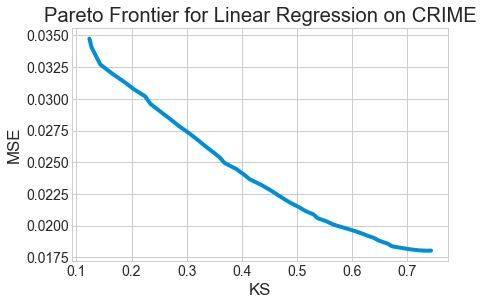

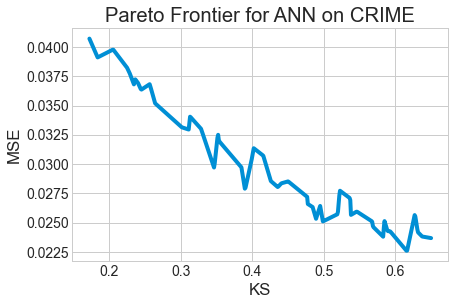

In [199]:
# Pareto frontier plot of linear regression
interploation_model = interp1d(KS_LR, MSE_LR, kind = "linear")

X_LR=np.linspace(KS_LR.min(), KS_LR.max(), 500)
Y_LR=interploation_model(X_LR)
 
plt.plot(X_LR, Y_LR)
plt.title("Pareto Frontier for Linear Regression on CRIME")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

# Pareto frontier plot of ANN
interploation_model = interp1d(KS_ANN, MSE_ANN, kind = "linear")
 
X_ANN=np.linspace(KS_ANN.min(), KS_ANN.max(), 500)
Y_ANN=interploation_model(X_ANN)
 
plt.plot(X_ANN, Y_ANN)
plt.title("Pareto Frontier for ANN on CRIME")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()



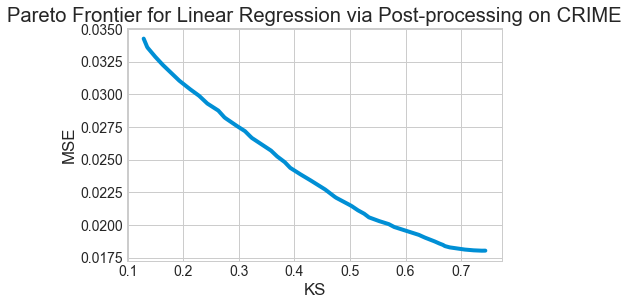

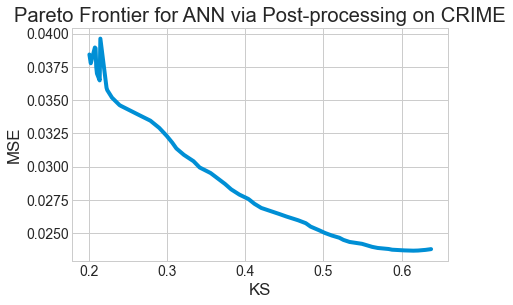

In [200]:
# Pareto frontier plot of linear regression
interploation_model = interp1d(P_KS_LR, P_MSE_LR, kind = "linear")

P_X_LR=np.linspace(P_KS_LR.min(), P_KS_LR.max(), 500)
P_Y_LR=interploation_model(P_X_LR)
 
plt.plot(P_X_LR, P_Y_LR)
plt.title("Pareto Frontier for Linear Regression via Post-processing on CRIME")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

# Pareto frontier plot of ANN
interploation_model = interp1d(P_KS_ANN, P_MSE_ANN, kind = "linear")
 
P_X_ANN=np.linspace(P_KS_ANN.min(), P_KS_ANN.max(), 500)
P_Y_ANN=interploation_model(P_X_ANN)
 
plt.plot(P_X_ANN, P_Y_ANN)
plt.title("Pareto Frontier for ANN via Post-processing on CRIME")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

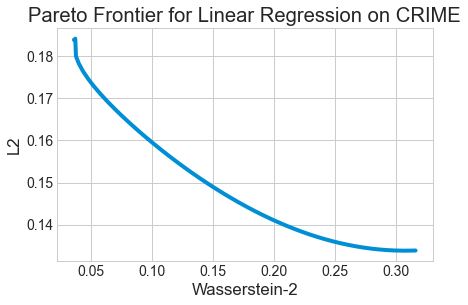

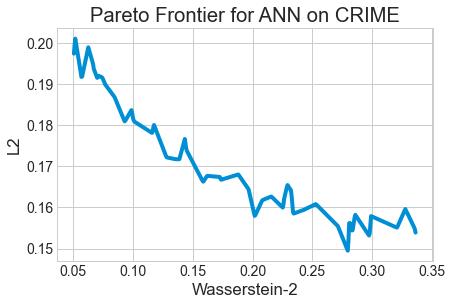

In [209]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(W2_LR, L2_LR, kind = "linear")

X_LR_W2=np.linspace(W2_LR.min(), W2_LR.max(), 500)
Y_LR_W2=interploation_model(X_LR_W2)
 
plt.plot(X_LR_W2, Y_LR_W2)
plt.title("Pareto Frontier for Linear Regression on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(W2_ANN, L2_ANN, kind = "linear")
 
X_ANN_W2=np.linspace(W2_ANN.min(), W2_ANN.max(), 500)
Y_ANN_W2=interploation_model(X_ANN_W2)
 
plt.plot(X_ANN_W2, Y_ANN_W2)
plt.title("Pareto Frontier for ANN on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

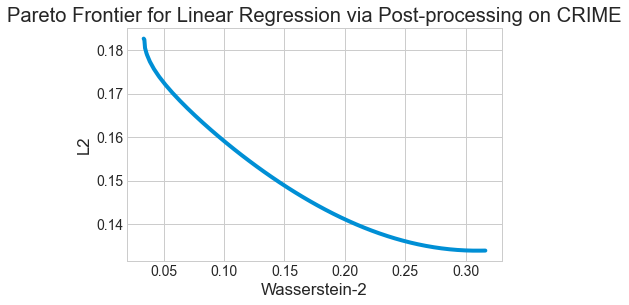

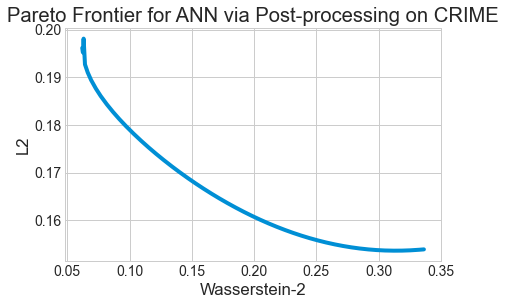

In [210]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(P_W2_LR, P_L2_LR, kind = "linear")

P_X_LR_W2=np.linspace(P_W2_LR.min(), P_W2_LR.max(), 500)
P_Y_LR_W2=interploation_model(P_X_LR_W2)
 
plt.plot(P_X_LR_W2, P_Y_LR_W2)
plt.title("Pareto Frontier for Linear Regression via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(P_W2_ANN, P_L2_ANN, kind = "linear")
 
P_X_ANN_W2=np.linspace(P_W2_ANN.min(), P_W2_ANN.max(), 500)
P_Y_ANN_W2=interploation_model(P_X_ANN_W2)
 
plt.plot(P_X_ANN_W2, P_Y_ANN_W2)
plt.title("Pareto Frontier for ANN via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

## MSE and KS of Linear Regression and ANN via the Post-processing Approach in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc..
We implement the post-processing approach ourselves since the authors of "Fair Regression with Wasserstein Barycenters" did not post their code. See the implementation in "Implementation of Fair Regression with Wasserstein Barycenters.py" and the resulting MSE, KS, and time recording are listed below.

In [161]:
# function that finds the barycenter by matching the cumulative distribution functions of two marginal/conditional random variables
def f_NIPS(Y_l, Y_t, Z_l, Z_t):
    u = np.unique(Z_l)
    nM = max([sum(Z_l==u[0]),sum(Z_l==u[1])])
    iM = np.argmax([sum(Z_l==u[0]),sum(Z_l==u[1])])
    nm = min([sum(Z_l==u[0]),sum(Z_l==u[1])])
    im = np.argmin([sum(Z_l==u[0]),sum(Z_l==u[1])])
    p = nm/len(Z_l)
    q = 1-p
    YF = np.zeros(len(Y_t))
    for i in range(0,len(Y_t)):
        print(i)
        if Z_t[i] == u[im]:
            dist_best = math.inf
            for t in np.linspace(min(Y_l),max(Y_l),100):
                tmp1 = sum(Y_l[Z_l==u[iM]] < t)/nM
                tmp2 = sum(Y_l[Z_l==u[im]] < Y_t[i])/nm
                dist = np.abs(tmp1-tmp2)
                if dist_best > dist:
                    dist_best = dist
                    ts = t
            YF[i] = p*Y_t[i]+q*ts
        else:
            dist_best = math.inf
            for t in np.linspace(min(Y_l),max(Y_l),100):
                tmp1 = sum(Y_l[Z_l==u[im]] < t)/nm
                tmp2 = sum(Y_l[Z_l==u[iM]] < Y_t[i])/nM
                dist = np.abs(tmp1-tmp2)
                if dist_best > dist:
                    dist_best = dist
                    ts = t
            YF[i] = q*Y_t[i]+p*ts
    return YF

In [162]:
# train and test sensitive variable and prediction: Z_l(t), Y_l(t)
Z_l = trainZ_list # for CRIME data, use trainZ_list[i] = trainX_list[i][:,96]
Z_t = testZ_list # for CRIME data, use testZ_list[i] = testX_list[i][:,96]
Y_l = Y_hat_list_l # for ANN results, use Y_hat_list_l_ANN instead
Y_t = Y_hat_list_t # for ANN results, use Y_hat_list_t_ANN instead

# compute the predictions on the test sets via the post-processing approach
Y_hat_chzhen_list = []
time_chzhen_list = []

for i in range(len(trainX_list)):
    t = perf_counter()
    Y_hat_chzhen_list.append(f_NIPS(Y_l[i], Y_t[i], Z_l[i], Z_t[i]))
    time_chzhen_list.append(perf_counter() - t)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


In [165]:
# compute MSE and KS
MSE_chzhen_list = []
KS_chzhen_list = []
W2_chzhen_list = []

for i in range(len(trainX_list)):
    MSE_chzhen_list.append(((testY_list[i][:,0] - Y_hat_chzhen_list[i])**2).mean(axis = 0))   # MSE
    KS_result_chzhen = stats.ks_2samp(Y_hat_chzhen_list[i][Z_t[i] == 0], Y_hat_chzhen_list[i][Z_t[i] == 1]) # KS
    KS_chzhen_list.append(KS_result_chzhen[0])
    W2_chzhen_list.append(np.sqrt(ot.emd2_1d(Y_hat_chzhen_list[i][Z_t[i] == 0], Y_hat_chzhen_list[i][Z_t[i] == 1])))
    
L2_chzhen_list = np.sqrt(MSE_chzhen_list)


In [166]:
MSE_chzhen_list, KS_chzhen_list, L2_chzhen_list, W2_chzhen_list, time_chzhen_list

([0.03894169034684544,
  0.03337093400456026,
  0.029247435381513733,
  0.043735122036564045,
  0.028307104203970805],
 [0.14336917562724014,
  0.19753086419753085,
  0.16827136720485855,
  0.057172557172557176,
  0.1303986710963455],
 array([0.19733649, 0.18267713, 0.17101882, 0.20912944, 0.16824715]),
 [0.028601377643109483,
  0.034554968249569225,
  0.0544072837358958,
  0.015106578500782472,
  0.03286987206862379],
 [25.721354610999697,
  25.88722537799913,
  26.419554047999554,
  27.161573374003638,
  27.58213986600458])

In [167]:
# compute the predictions on the test sets via the post-processing approach
Y_hat_chzhen_list_ANN = []
time_chzhen_list_ANN = []

for i in range(len(trainX_list)):
    t = perf_counter()
    Y_hat_chzhen_list_ANN.append(f_NIPS(Y_HatPathList_l_ANN[i][0], Y_HatPathList_t_ANN[i][0], Z_l[i], Z_t[i]))
    time_chzhen_list_ANN.append(perf_counter() - t)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


In [171]:
# compute MSE and KS
MSE_chzhen_list_ANN = []
KS_chzhen_list_ANN = []
W2_chzhen_list_ANN = []

for i in range(len(trainX_list)):
    MSE_chzhen_list_ANN.append(((testY_list[i][:,0] - Y_hat_chzhen_list_ANN[i])**2).mean(axis = 0))   # MSE
    KS_result_chzhen = stats.ks_2samp(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1]) # KS
    KS_chzhen_list_ANN.append(KS_result_chzhen[0])
    W2_chzhen_list_ANN.append(np.sqrt(ot.emd2_1d(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1])))
    
L2_chzhen_list_ANN = np.sqrt(MSE_chzhen_list_ANN)

In [172]:
MSE_chzhen_list_ANN, KS_chzhen_list_ANN, L2_chzhen_list_ANN, W2_chzhen_list_ANN, time_chzhen_list_ANN

([0.04813599122426715,
  0.040453505845525484,
  0.03408832391274344,
  0.04647472966942803,
  0.036721557543494536],
 [0.1863799283154122,
  0.10168940870695256,
  0.1262035254036439,
  0.11538461538461539,
  0.12209302325581395],
 array([0.21939916, 0.20113057, 0.18463024, 0.21557998, 0.1916287 ]),
 [0.07960866526534026,
  0.04657807145516025,
  0.05050234476666286,
  0.05827144677705685,
  0.03705778068328517],
 [26.036092733993428,
  25.56152604300587,
  26.11628175599617,
  26.25049288100854,
  24.714314696000656])

### Recording chzhen's results

MSE_chzhen_list = [0.03894169034684544,
  0.03337093400456026,
  0.029247435381513733,
  0.043735122036564045,
  0.028307104203970805]
KS_chzhen_list = [0.14336917562724014,
  0.19753086419753085,
  0.16827136720485855,
  0.057172557172557176,
  0.1303986710963455]
time_chzhen_list = [6271.129221878,
  6865.3056517429995,
  6682.171541546999,
  6639.455036824998,
  6527.266549924003]
 

MSE_chzhen_list_ANN = [0.04132980387227846,
  0.038465852325328696,
  0.02801805644418558,
  0.04707522705111268,
  0.031204556044760367]
KS_chzhen_list_ANN = [0.13333333333333333,
  0.1309291747888239,
  0.12975855428825359,
  0.10602910602910603,
  0.14285714285714285]
time_chzhen_list_ANN = [7593.746866715002,
  7754.263235025006,
  6561.0633790659995,
  6227.002467115002,
  6511.589547302006]

## Generate Figures

In [208]:
# mean and standard deviation of the MSE and KS resulting from the comparison methods:

MSE_origin_mean = np.mean(MSE_origin_list)
MSE_d_mean = np.mean(MSE_d_list)
MSE_fair_mean = np.mean(MSE_fair_list)
P_MSE_fair_mean = np.mean(P_MSE_fair_LR)
MSE_chzhen_mean = np.mean(MSE_chzhen_list)

MSE_origin_std = np.std(MSE_origin_list)
MSE_d_std = np.std(MSE_d_list)
MSE_fair_std = np.std(MSE_fair_list)
P_MSE_fair_std = np.std(P_MSE_fair_LR)
MSE_chzhen_std = np.std(MSE_chzhen_list)

L2_origin_mean = np.mean(L2_origin_list)
L2_d_mean = np.mean(L2_d_list)
L2_fair_mean = np.mean(L2_fair_list)
P_L2_fair_mean = np.mean(P_L2_fair_LR)
L2_chzhen_mean = np.mean(L2_chzhen_list)

L2_origin_std = np.std(L2_origin_list)
L2_d_std = np.std(L2_d_list)
L2_fair_std = np.std(L2_fair_list)
P_L2_fair_std = np.std(P_L2_fair_LR)
L2_chzhen_std = np.std(L2_chzhen_list)

KS_origin_mean = np.mean(KS_origin_list)
KS_d_mean = np.mean(KS_d_list)
KS_fair_mean = np.mean(KS_fair_list)
P_KS_fair_mean = np.mean(P_KS_fair_LR) 
KS_chzhen_mean = np.mean(KS_chzhen_list)

KS_origin_std = np.std(KS_origin_list)
KS_d_std = np.std(KS_d_list)
KS_fair_std = np.std(KS_fair_list)
P_KS_fair_std = np.std(P_KS_fair_LR)
KS_chzhen_std = np.std(KS_chzhen_list)

W2_origin_mean = np.mean(W2_origin_list)
W2_d_mean = np.mean(W2_d_list)
W2_fair_mean = np.mean(W2_fair_list)
P_W2_fair_mean = np.mean(P_W2_fair_LR) 
W2_chzhen_mean = np.mean(W2_chzhen_list)

W2_origin_std = np.std(W2_origin_list)
W2_d_std = np.std(W2_d_list)
W2_fair_std = np.std(W2_fair_list)
P_W2_fair_std = np.std(P_W2_fair_LR)
W2_chzhen_std = np.std(W2_chzhen_list)

MSE_origin_mean_ANN = np.mean(MSE_origin_list_ANN)
MSE_d_mean_ANN = np.mean(MSE_d_list_ANN)
MSE_fair_mean_ANN = np.mean(MSE_fair_list_ANN)
P_MSE_fair_mean_ANN = np.mean(P_MSE_fair_ANN)
MSE_chzhen_mean_ANN = np.mean(MSE_chzhen_list_ANN)

MSE_origin_std_ANN = np.std(MSE_origin_list_ANN)
MSE_d_std_ANN = np.std(MSE_d_list_ANN)
MSE_fair_std_ANN = np.std(MSE_fair_list_ANN)
P_MSE_fair_std_ANN = np.std(P_MSE_fair_ANN)
MSE_chzhen_std_ANN = np.std(MSE_chzhen_list_ANN)

L2_origin_mean_ANN = np.mean(L2_origin_list_ANN)
L2_d_mean_ANN = np.mean(L2_d_list_ANN)
L2_fair_mean_ANN = np.mean(L2_fair_list_ANN)
P_L2_fair_mean_ANN = np.mean(P_L2_fair_ANN)
L2_chzhen_mean_ANN = np.mean(L2_chzhen_list_ANN)

L2_origin_std_ANN = np.std(L2_origin_list_ANN)
L2_d_std_ANN = np.std(L2_d_list_ANN)
L2_fair_std_ANN = np.std(L2_fair_list_ANN)
P_L2_fair_std_ANN = np.std(P_L2_fair_ANN)
L2_chzhen_std_ANN = np.std(L2_chzhen_list_ANN)

KS_origin_mean_ANN = np.mean(KS_origin_list_ANN)
KS_d_mean_ANN = np.mean(KS_d_list_ANN)
KS_fair_mean_ANN = np.mean(KS_fair_list_ANN)
P_KS_fair_mean_ANN = np.mean(P_KS_fair_ANN)
KS_chzhen_mean_ANN = np.mean(KS_chzhen_list_ANN)

KS_origin_std_ANN = np.std(KS_origin_list_ANN)
KS_d_std_ANN = np.std(KS_d_list_ANN)
KS_fair_std_ANN = np.std(KS_fair_list_ANN)
P_KS_fair_std_ANN = np.std(P_KS_fair_ANN)
KS_chzhen_std_ANN = np.std(KS_chzhen_list_ANN)

W2_origin_mean_ANN = np.mean(W2_origin_list_ANN)
W2_d_mean_ANN = np.mean(W2_d_list_ANN)
W2_fair_mean_ANN = np.mean(W2_fair_list_ANN)
P_W2_fair_mean_ANN = np.mean(P_W2_fair_ANN) 
W2_chzhen_mean_ANN = np.mean(W2_chzhen_list_ANN)

W2_origin_std_ANN = np.std(W2_origin_list_ANN)
W2_d_std_ANN = np.std(W2_d_list_ANN)
W2_fair_std_ANN = np.std(W2_fair_list_ANN)
P_W2_fair_std_ANN = np.std(P_W2_fair_ANN)
W2_chzhen_std_ANN = np.std(W2_chzhen_list_ANN)

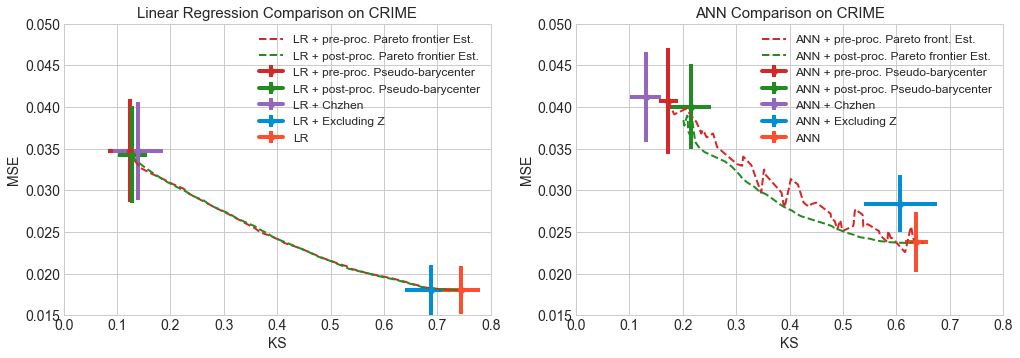

In [220]:
# Generate Figure
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight is name of style

axs[0].errorbar(KS_fair_mean, MSE_fair_mean, xerr=KS_fair_std, yerr=MSE_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_KS_fair_mean, P_MSE_fair_mean, xerr=P_KS_fair_std, yerr=P_MSE_fair_std, fmt='-o', color = 'forestgreen') # LR + post-processing pseudo-barycenter
axs[0].errorbar(KS_chzhen_mean, MSE_chzhen_mean, xerr=KS_chzhen_std, yerr=MSE_chzhen_std, fmt='-o',color = '#9467bd') # LR + chzhen
axs[0].errorbar(KS_d_mean, MSE_d_mean, xerr=KS_d_std, yerr=MSE_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(KS_origin_mean, MSE_origin_mean, xerr=KS_origin_std, yerr=MSE_origin_std, fmt='-o') # LR
axs[0].plot(X_LR,Y_LR,linewidth = 2, linestyle='dashed',color = '#d62728') # data representation
axs[0].plot(P_X_LR,P_Y_LR,linewidth = 2, linestyle='dashed',color = 'forestgreen') # post-processing

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + pre-proc. Pareto frontier Est.','LR + post-proc. Pareto frontier Est.','LR + pre-proc. Pseudo-barycenter','LR + post-proc. Pseudo-barycenter','LR + Chzhen','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('MSE', fontsize=14)
axs[0].set_xlabel('KS', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME", fontsize=15)
axs[0].set_ylim(0.015, 0.05)
axs[0].set_xlim(0, 0.8)


axs[1].errorbar(KS_fair_mean_ANN, MSE_fair_mean_ANN, xerr=KS_fair_std_ANN, yerr=MSE_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_KS_fair_mean_ANN, P_MSE_fair_mean_ANN, xerr=P_KS_fair_std_ANN, yerr=P_MSE_fair_std_ANN, fmt='-o', color = 'forestgreen') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(KS_chzhen_mean_ANN, MSE_chzhen_mean_ANN, xerr=KS_chzhen_std_ANN, yerr=MSE_chzhen_std_ANN, fmt='-o',color = '#9467bd') # ANN + chzhen
axs[1].errorbar(KS_d_mean_ANN, MSE_d_mean_ANN, xerr=KS_d_std_ANN, yerr=MSE_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(KS_origin_mean_ANN, MSE_origin_mean_ANN, xerr=KS_origin_std_ANN, yerr=MSE_origin_std_ANN, fmt='-o') # ANN
axs[1].plot(X_ANN,Y_ANN,linewidth = 2, linestyle='dashed',color = '#d62728') # data representation
axs[1].plot(P_X_ANN,P_Y_ANN,linewidth = 2, linestyle='dashed',color = 'forestgreen') # post-processing

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + pre-proc. Pareto front. Est.','ANN + post-proc. Pareto frontier Est.','ANN + pre-proc. Pseudo-barycenter','ANN + post-proc. Pseudo-barycenter','ANN + Chzhen','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('MSE', fontsize=14)
axs[1].set_xlabel('KS', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME", fontsize=15)
axs[1].set_ylim(0.015, 0.05)
axs[1].set_xlim(0, 0.8)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier CRIME Correction version 8', dpi=400,bbox_inches='tight')

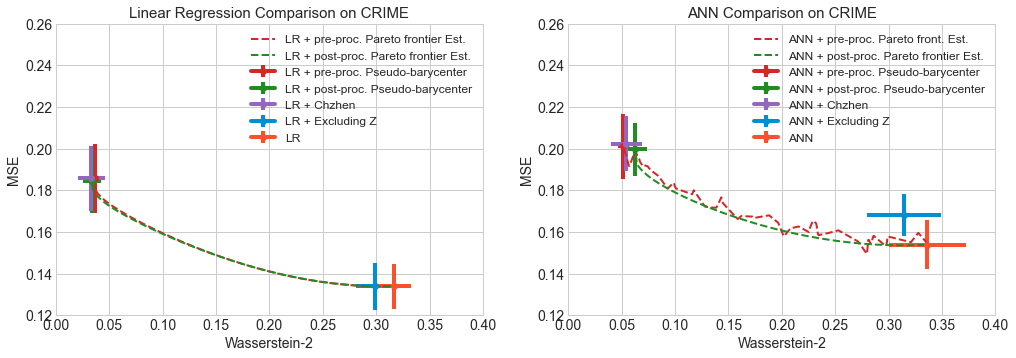

In [216]:
# Generate Figure: L2 vs W2
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight is name of style

axs[0].errorbar(W2_fair_mean, L2_fair_mean, xerr=W2_fair_std, yerr=L2_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_W2_fair_mean, P_L2_fair_mean, xerr=P_W2_fair_std, yerr=P_L2_fair_std, fmt='-o', color = 'forestgreen') # LR + post-processing pseudo-barycenter
axs[0].errorbar(W2_chzhen_mean, L2_chzhen_mean, xerr=W2_chzhen_std, yerr=L2_chzhen_std, fmt='-o',color = '#9467bd') # LR + chzhen
axs[0].errorbar(W2_d_mean, L2_d_mean, xerr=W2_d_std, yerr=L2_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(W2_origin_mean, L2_origin_mean, xerr=W2_origin_std, yerr=L2_origin_std, fmt='-o') # LR
axs[0].plot(X_LR_W2,Y_LR_W2,linewidth = 2, linestyle='dashed', color = '#d62728') # data representation
axs[0].plot(P_X_LR_W2,P_Y_LR_W2,linewidth = 2, linestyle='dashed', color = 'forestgreen') # post-processing


axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + pre-proc. Pareto frontier Est.','LR + post-proc. Pareto frontier Est.','LR + pre-proc. Pseudo-barycenter','LR + post-proc. Pseudo-barycenter','LR + Chzhen','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('MSE', fontsize=14)
axs[0].set_xlabel('Wasserstein-2', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME", fontsize=15)
axs[0].set_ylim(0.12, 0.26)
axs[0].set_xlim(0, 0.4)


axs[1].errorbar(W2_fair_mean_ANN, L2_fair_mean_ANN, xerr=W2_fair_std_ANN, yerr=L2_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_W2_fair_mean_ANN, P_L2_fair_mean_ANN, xerr=P_W2_fair_std_ANN, yerr=P_L2_fair_std_ANN, fmt='-o', color = 'forestgreen') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(W2_chzhen_mean_ANN, L2_chzhen_mean_ANN, xerr=W2_chzhen_std_ANN, yerr=L2_chzhen_std_ANN, fmt='-o',color = '#9467bd') # ANN + chzhen
axs[1].errorbar(W2_d_mean_ANN, L2_d_mean_ANN, xerr=W2_d_std_ANN, yerr=L2_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(W2_origin_mean_ANN, L2_origin_mean_ANN, xerr=W2_origin_std_ANN, yerr=L2_origin_std_ANN, fmt='-o') # ANN
axs[1].plot(X_ANN_W2,Y_ANN_W2,linewidth = 2, linestyle='dashed', color = '#d62728') # data representation
axs[1].plot(P_X_ANN_W2,P_Y_ANN_W2,linewidth = 2, linestyle='dashed', color = 'forestgreen') # post-processing


#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + pre-proc. Pareto front. Est.','ANN + post-proc. Pareto frontier Est.','ANN + pre-proc. Pseudo-barycenter','ANN + post-proc. Pseudo-barycenter','ANN + Chzhen','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('MSE', fontsize=14)
axs[1].set_xlabel('Wasserstein-2', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME", fontsize=15)
axs[1].set_ylim(0.12, 0.26)
axs[1].set_xlim(0, 0.4)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier CRIME L2 vs W2 version 6', dpi=400,bbox_inches='tight')